# [IT8701] Introduction to Programming for Data Science: Singapore Labour Market Analysis

__Name__: Sng Tian Hao, Keith <br>
__Student ID__: 1273381F <br>
__Class__: C <br>
__Tutor__: Chia Yao An Kendrick

## Table of Contents
- [Import Libraries & Create MySQL Connection](#1)
- [Data Analysis](#2)
    - [Global vs Singapore Unemployment (Topline Comparison)](#2_1)
    - [Singapore Retrenchment Rates by Industry](#2_1)
    - [Turnover Rate by Industry](#2_2)
    - [Wage Comparison Across Industries](#2_4)
    - [Weekly Hours Worked Across Industries](#2_5)
    - [Leave Benefits by Industry](#2_6)
    - [Flexible Working Arranagements (FWAs) by Industry](#2_7)
- [Limitations of Study](#3)
- [Conclusion](#4)

<br>__Introduction__<br>
In recent months, there has been growing sentiment that Singapore's economy is facing significant challenges. Concerns about economic downturns, fluctuating markets, and domestic economic pressures have sparked discussions about the state of the job market. Despite these worries, the Ministry of Manpower’s (MOM) outlook suggests that growth opportunities may still be on the horizon.

As such, this analysis seeks to assess the current state of Singapore’s labour market amidst prevailing concerns. Specifically, we will focus on comparing Singapore’s labour market globally and explore job opportunities across various industries and sectors, with the aim of helping job-seekers achieve both job security and satisfaction.

__Aim__<br>
In particular, we aim to answer the following questions:
1. What is the current state of Singapore’s labour market in comparison to other countries?
2. Which sectors or industries in Singapore offer the greatest job security in the present economic climate?
3. Where can job-seekers look for opportunities within the various sectors or industries?
4. How can job-seekers find employment that aligns with their expectations and offers satisfaction?


__Datasets used__<br>
1. [Overall Unemployment Rate, Annual](https://beta.data.gov.sg/datasets?query=Overall+Unemployment+Rate&resultId=d_e3598914c86699a9a36e68190f78c59a)
2. [OECD Annual Unemployment Rates](https://data-explorer.oecd.org/vis?df%5Bds%5D=dsDisseminateFinalDMZ&df%5Bid%5D=DSD_LFS%2540DF_IALFS_UNE_M&df%5Bag%5D=OECD.SDD.TPS&df%5Bvs%5D=1.0&dq=..._Z.Y._T.Y_GE15..A&lom=LASTNPERIODS&lo=14&to%5BTIME_PERIOD%5D=false&vw=tb)
3. [World Bank Country and Lending Groups](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups)
4. [Retrenchment By Industry](https://beta.data.gov.sg/collections/698/datasets/d_c794e2ad25c1d3bb7965d13dffd0b411/view)
5. [Average Monthly Recruitment/Resignation Rate by Industry and Occupational Group](https://beta.data.gov.sg/collections/682/datasets/d_e6aeec36ef233579b42fa4a53d6b68cb/view)
6. [Occupational Wages within each Major Occupational Group by Industry](https://beta.data.gov.sg/datasets?query=Occupational+Wages&resultId=d_43a37d383fe7b33368f1a3465467571d)
7. [Average Weekly Paid Hours Worked Per Employee by Industry and Type of Employment](https://beta.data.gov.sg/collections/685/datasets/d_fad3e6e2455bf38a1dcf1b11f436cd88/view)
8. [Distribution of Full-Time Employees By Annual Leave Entitlement](https://beta.data.gov.sg/collections/693/datasets/d_a1a97c36b2299a0805d8eabd4774da72/view)
9. [Proportion of Establishments That Provided Non-Statutory Leave by Type](https://beta.data.gov.sg/datasets?agencies=Ministry+of+Manpower+%28MOM%29&query=industry+%28level+3%29&resultId=d_c8db149104046725174a56b9d3e79926)
10. [Proportion of Establishments Offering Scheduled FWAs-Industry](https://beta.data.gov.sg/collections/1948/datasets/d_9190c1b4524b6361ce6afdffd39fa94e/view)


# 1. Import Libraries & Create MySQL Connection <a id = '1'></a>

In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
# Create connection
con = mysql.connector.connect(user='root', password='1273381F', host='127.0.0.1', database='SGMARKET')

if con.is_connected():
    print('MySQL connection successful!')
else:
    print('Connection failed, lease check MySQL connection.')

cursor = con.cursor()

MySQL connection successful!


# 2. Data Analysis <a id = '2'></a> 

## Singapore vs Global Unemployment (Topline Comparison) <a id = '2_1'></a>

Based on the World Bank Country classification by income group, Singapore is considered high income.<br>
Therefore, to compare how Singapore's labour market is doing globally, we will benchmark our unemployment rate within the high income bracket group.

In [3]:
# Determine Singapore's income bracket based on World Bank classification
query = '''
SELECT * FROM WB_CLASS
WHERE ECONOMY = 'Singapore'
'''
singapore_class = pd.read_sql(query, con)

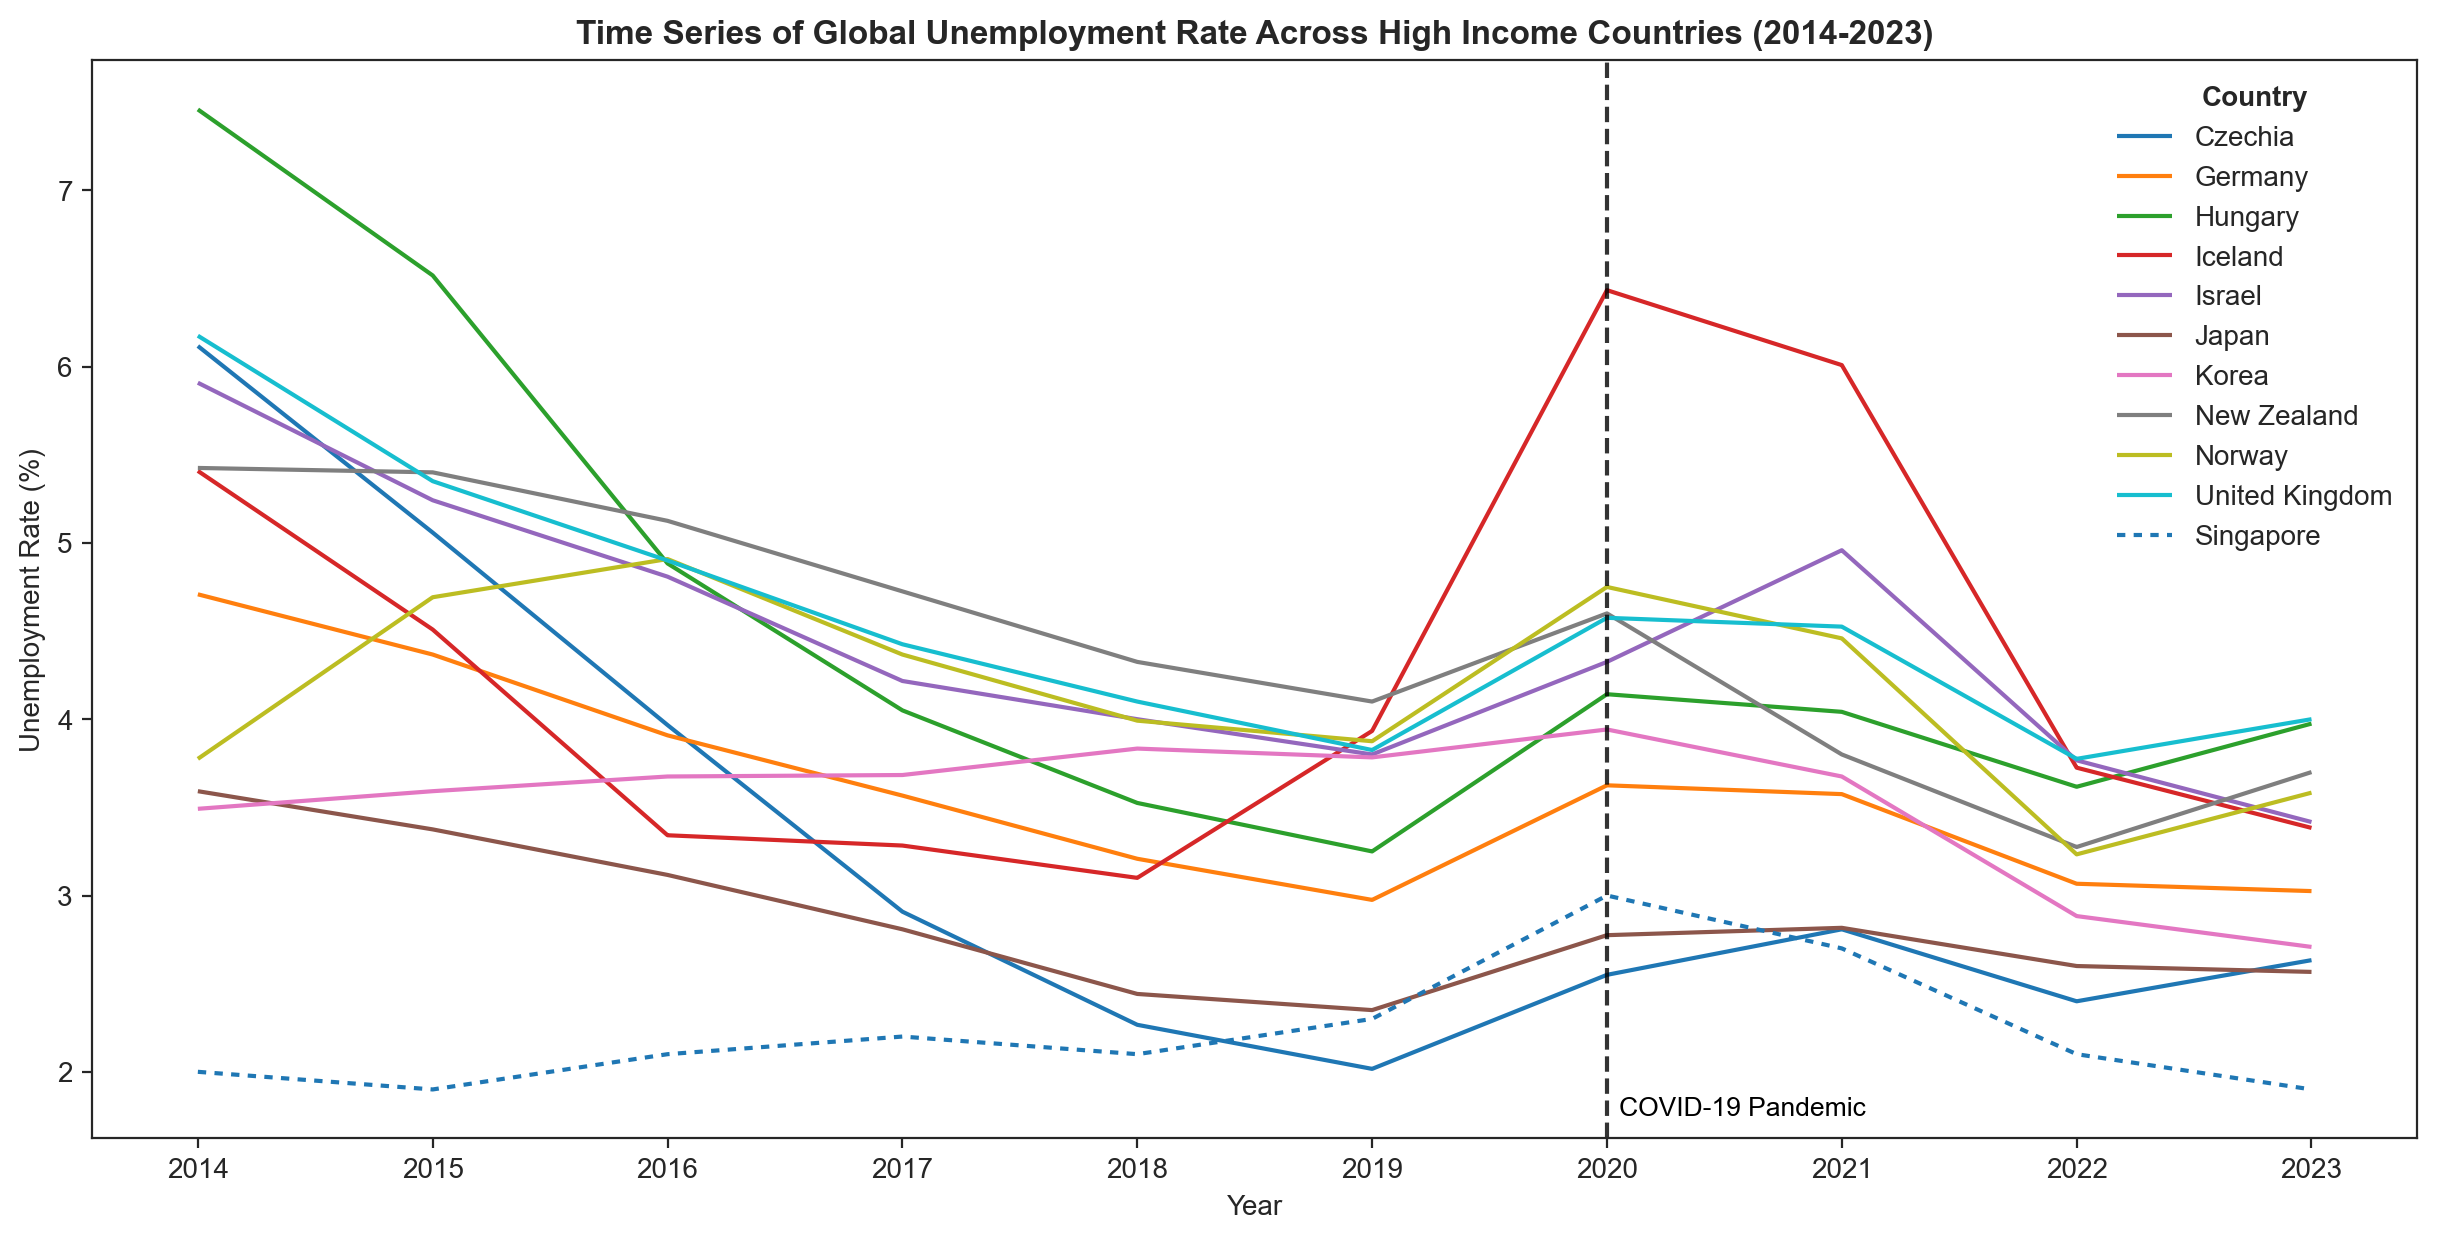

In [4]:
# Extract 10 year global unemployment rate by country and income group bracket info from world bank
query = '''
SELECT T1.*, T2.INCOME_GROUP
FROM OECD T1
INNER JOIN WB_CLASS T2
    ON T1.REF_CODE = T2.CODE
WHERE T1.YEAR >= 2014
'''
oecd = pd.read_sql(query, con)

# Income group split
n_high_income = oecd[['REF_AREA', 'INCOME_GROUP']].drop_duplicates()['INCOME_GROUP'].value_counts()['High income']
n_upper_mid_income = oecd[['REF_AREA', 'INCOME_GROUP']].drop_duplicates()['INCOME_GROUP'].value_counts()['Upper middle income']

# Get top 10 countries with lowest unemployment rates within high income bracket for comparison
top_10_countries = oecd[oecd['INCOME_GROUP'] == 'High income'].groupby('REF_AREA')['UNEMPLOYMENT_RATE'].mean().nsmallest(10).index
oecd_high_income_top_10 = oecd[oecd['REF_AREA'].isin(top_10_countries)]

# Extract Singapore unemployment data from 2014
query = '''
SELECT * FROM SG_UNEMPLOYMENT
WHERE YEAR >= 2014
'''
sg_unemployment = pd.read_sql(query, con)
sg_unemployment['REF_AREA'] = 'Singapore'

# Concat OECD and SG unemployment data
oecd_sg_comb = pd.concat([oecd_high_income_top_10[['YEAR', 'REF_AREA', 'UNEMPLOYMENT_RATE']], sg_unemployment[['YEAR', 'REF_AREA', 'UNEMPLOYMENT_RATE']]], ignore_index=True)

# Plot trend for top 10 OECD countries vs Singapore
plt.figure(figsize=(15,7))
sns.set_style('ticks')
sns.set_palette(sns.color_palette(), n_colors=11)
ax = sns.lineplot(x='YEAR', y='UNEMPLOYMENT_RATE', hue='REF_AREA', data=oecd_sg_comb, style='REF_AREA', dashes = {'Singapore': (2,2), 
                                                                                                                  'Iceland':(1,0), 'United Kingdom':(1,0), 'Norway':(1,0), 
                                                                                                                  'Israel':(1,0), 'Japan':(1,0), 'New Zealand':(1,0), 
                                                                                                                  'Germany':(1,0), 'Korea':(1,0), 'Czechia':(1,0), 'Hungary':(1,0)})

plt.title('Time Series of Global Unemployment Rate Across High Income Countries (2014-2023)', weight='bold')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(np.arange(2014, 2024), np.arange(2014, 2024))
plt.legend(title='Country', frameon=False, title_fontproperties={'weight':'bold'})

ax.axvline(x=2020, color='black', ls='--', alpha=0.8)
plt.text(2020.05, 1.75, "COVID-19 Pandemic", color='black', ha='left', fontsize=9.5)

plt.show()

<u><b>Overview</b></u><br>
The OECD unemploment dataset contains data from 2014 to 2023 across 39 unique areas. Among which, 35 are high income countries whereas 4 are upper middle income countries.


High income countries in OECD unemployment dataset:
Australia, Austria, Belgium, Bulgaria, Canada, Chile, Colombia, Costa Rica, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, Korea, Latvia, Lithuania, Luxembourg, Mexico, Netherlands, New Zealand, Norway, Poland, Portugal, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, Türkiye, United Kingdom, United States.


At a glance, there are many European countries in the list of high income countries.Given that European countries tend to have generous unemployment benefits (e.g., Italy, France) which may promote unemployment rates, an aggregation of unemployment rate by income group may inflate the mean unemployment rate within the high income bracket.

Thus, to triangulate where Singapore stands within the high income bracket, the top 10 countries with the lowest average unemployment rate over the past 10 years was used.

<u><b>Insights</b></u><br>
The time series graph indicates that Singapore generally experienced the lowest unemployment rates compared to the other ten countries examined.

Historically, the unemployment rates in Singapore remained stable at around 2.0% for several years. However, there was a notable spike in 2020 due to the impact of the COVID-19 pandemic. Despite this, Singapore's unemployment rate eventually returned to pre-pandemic levels, reaching a 10-year low of 1.9%. This suggests that Singapore's labour market is performing well globally, reflecting the strong economic resilience and effective local employment policies.

## Singapore Retrenchment Rates by Industry <a id = '2_2'></a>

Here, retrenchment refers to the termination of permanent employees due to redundancy and/or early termination of term contract employees due to redundancy (source: [Ministry of Manpower](https://stats.mom.gov.sg/Pages/Retrenchment-Summary-Table.aspx#:~:text=Retrenchment%20refers%20to%20the%20termination,contract%20employees%20due%20to%20redundancy.)).

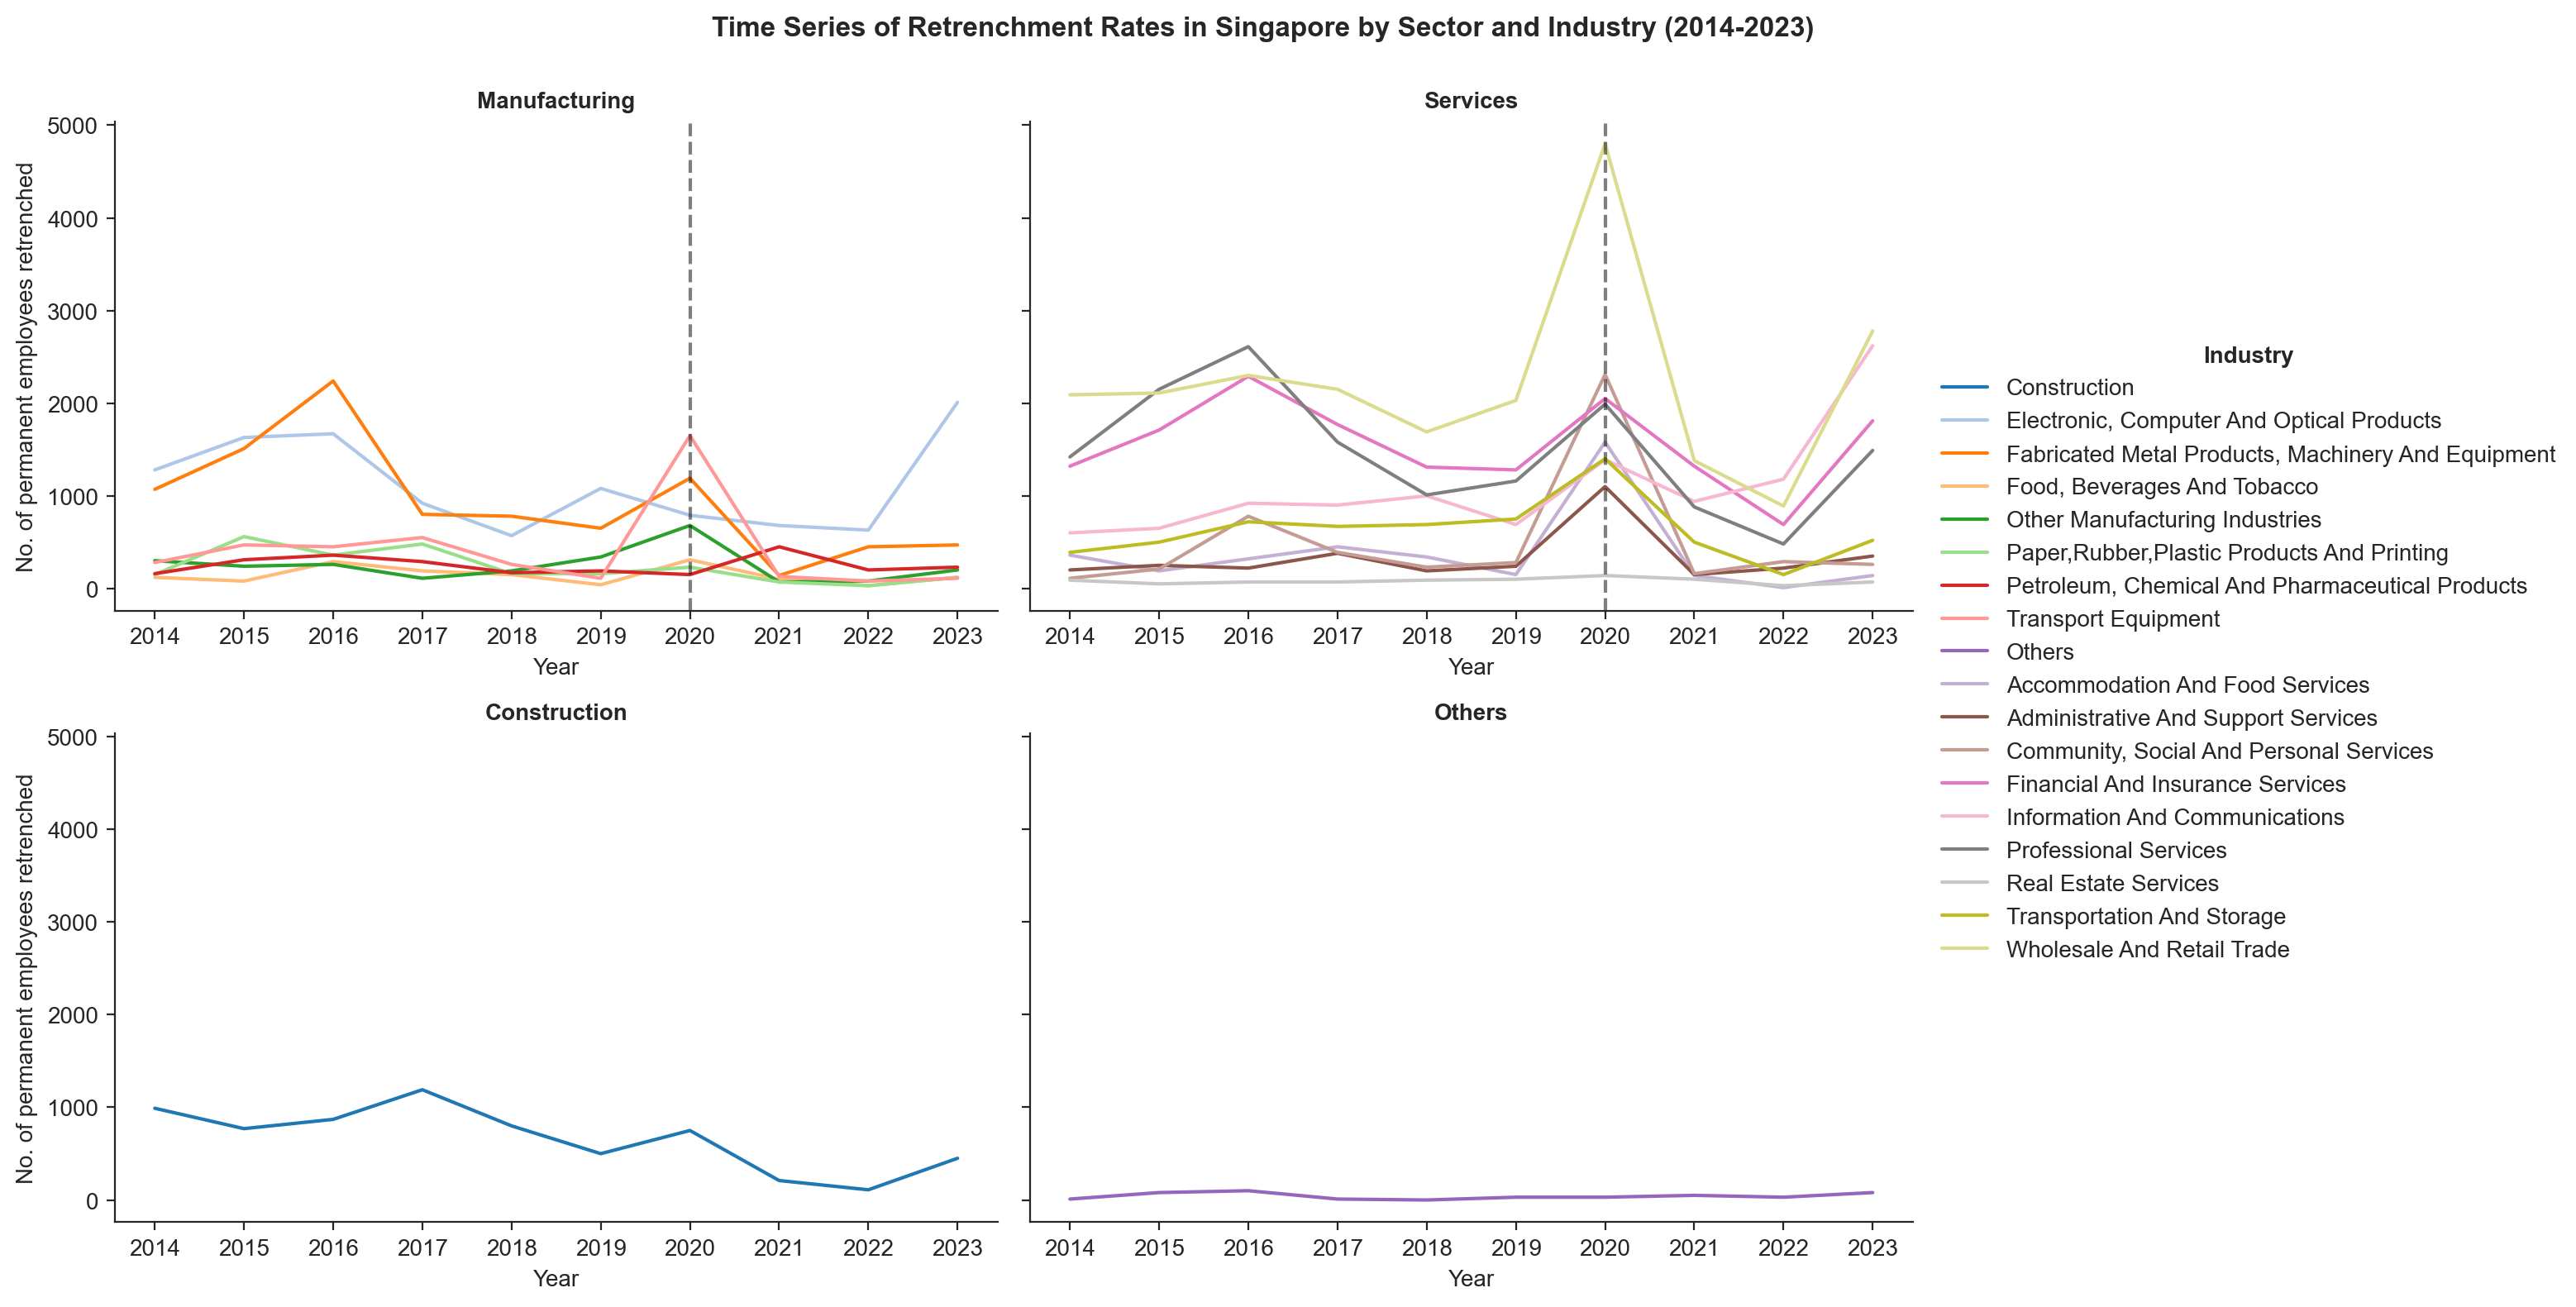

================= TOP 5 INDUSTRIES WITH HIGHEST RETRENCHMENT LEVELS =================
   YEAR      INDUSTRY1                                  INDUSTRY2  RETRENCH_PERM
0  2023       Services                 Wholesale And Retail Trade         2780.0
1  2023       Services             Information And Communications         2620.0
2  2023  Manufacturing  Electronic, Computer And Optical Products         2010.0
3  2023       Services           Financial And Insurance Services         1810.0
4  2023       Services                      Professional Services         1490.0


In [5]:
# Exract 10 year retrenchment data by industry
query = '''
SELECT * FROM RETRENCHMENT
WHERE YEAR >= 2014
'''
retrenchment = pd.read_sql(query, con)

# Data cleaning and preparation
retrenchment['INDUSTRY1'] = retrenchment['INDUSTRY1'].str.title() # Convert industry names to title case for presentation
retrenchment['INDUSTRY2'] = retrenchment['INDUSTRY2'].str.title() # Convert industry names to title case for presentation
retrenchment_group = retrenchment.groupby(['YEAR', 'INDUSTRY1', 'INDUSTRY2'])['RETRENCH_PERM'].sum().reset_index() # Group by to aggregate level 2 industry totals
retrenchment_group

# Plot trend for industry
sns.set_style('ticks')

ax = sns.relplot(x='YEAR', y='RETRENCH_PERM', hue='INDUSTRY2', col='INDUSTRY1', data=retrenchment_group, kind='line', 
    col_wrap=2, col_order=['Manufacturing', 'Services', 'Construction', 'Others'], height=4, aspect=1.5,
    palette = sns.color_palette(palette = 'tab20'),
    facet_kws={'sharey': True, 'sharex': False})

ax.fig.suptitle('Time Series of Retrenchment Rates in Singapore by Sector and Industry (2014-2023)', fontweight='bold')
ax.set(xlabel='Year', ylabel='No. of permanent employees retrenched')
ax._legend.set_title(title='Industry', prop={'weight': 'bold'})
ax.set_titles(col_template='{col_name}', fontweight='bold')

plt.subplots_adjust(hspace=0.25, top=0.9)

for i in range(4):
    ax.axes[i].set_xticks(np.arange(2014, 2024), np.arange(2014, 2024))
    if i < 2:
        ax.axes[i].axvline(x=2020, color='black', ls='--', alpha=0.5)        

plt.show()

# Zoom into 2023 to see which industries have highest retrenchment
print('================= TOP 5 INDUSTRIES WITH HIGHEST RETRENCHMENT LEVELS =================')
print(retrenchment_group[retrenchment_group['YEAR'] == 2023].nlargest(columns='RETRENCH_PERM', n=5).reset_index(drop=True))

retrenchment_2023 = retrenchment_group[retrenchment_group['YEAR'] == 2023]
fig = go.Figure(data = [go.Pie(labels=retrenchment_2023['INDUSTRY2'], values=retrenchment_2023['RETRENCH_PERM'], hole=0.5, 
                        marker=dict(colors=px.colors.qualitative.Alphabet),
                        hovertemplate = """<b>Industry</b>: %{label}
                            <br><b>No. Retrenched</b>: %{value}
                            <br><b>Percent Retrenched</b>: %{percent:.2%}<extra></extra>
                        """)])
fig.update_layout(title='Latest Retrenchment Rate Data by Industry (2023)', legend_title_text='<b>Industry</b>',
                    width=1000, height=620)

fig.show()

# Export html
# fig.write_html("../03_Figures/Retrenchment Rate Pie Chart by Industry.html")

<u><b>Analysis</b></u><br>
Although Singapore's unemployment rate is low compared to other countries globally, it's important to understand the local market dynamics and job security across various sectors and industries. To shed light on this, retrenchment data from the past 10 years was analysed to plot retrenchment rates across 18 different industries across 4 sectors.

The resultant time series will allow job-seekers to identify industries that are thriving or not doing well, providing valuable insights for job-seekers to better plan their careers within their chosen sector or industry.

<u><b>Insights</b></u><br>
Generally, there were unusual spikes in retrenchment in 2020 due to COVID-19 with retrenchment levels returning to pre-pandemic levels by 2022. However, certain industries continue to see rising retrenchment levels, possibly indicating the decline (either short-term or long-term) of these industries.

Broadly, most of this decline appears to be in the services sector, especially in Information & Communications, Wholesale & Retail Trade, Financial & Insurance Services, and 
Professional Services. In the manufacturing sector, the Electronic, Computer & Optical Products industry is also experiencing a slowdown with increased retrenchment.

## Turnover Rate by Industry <a id = '2_3'></a>

Here, average resignation (recruitment) rate is defined as the average number of persons who resigned (recruited) in a year divided by the avera​ge number of employees in the establishment (source: [Ministry of Manpower](https://stats.mom.gov.sg/iMAS_PdfLibrary/mrsd_qtlmr191_Technical_Note.pdf)).

Correlation between recruitment and resignation: 0.914 (p = 0.000)


======================== TOP 5 INDUSTRIES WITH HIGHEST RESIGNATION, RECRUITMENT & TURNOVER RATES ========================
       INDUSTRY1                            INDUSTRY2  RESIGNATION_MEAN  RECRUITMENT_MEAN  TURNOVER_MEAN
0       Services  Administrative And Support Services          2.633333          3.633333           1.00
1       Services      Accommodation And Food Services          2.450000          3.600000           1.15
2  Manufacturing          Food, Beverages And Tobacco          1.800000          3.000000           1.20
3       Services           Wholesale And Retail Trade          1.600000          3.100000           1.50
4       Services                 Real Estate Services          1.500000          2.300000           0.80


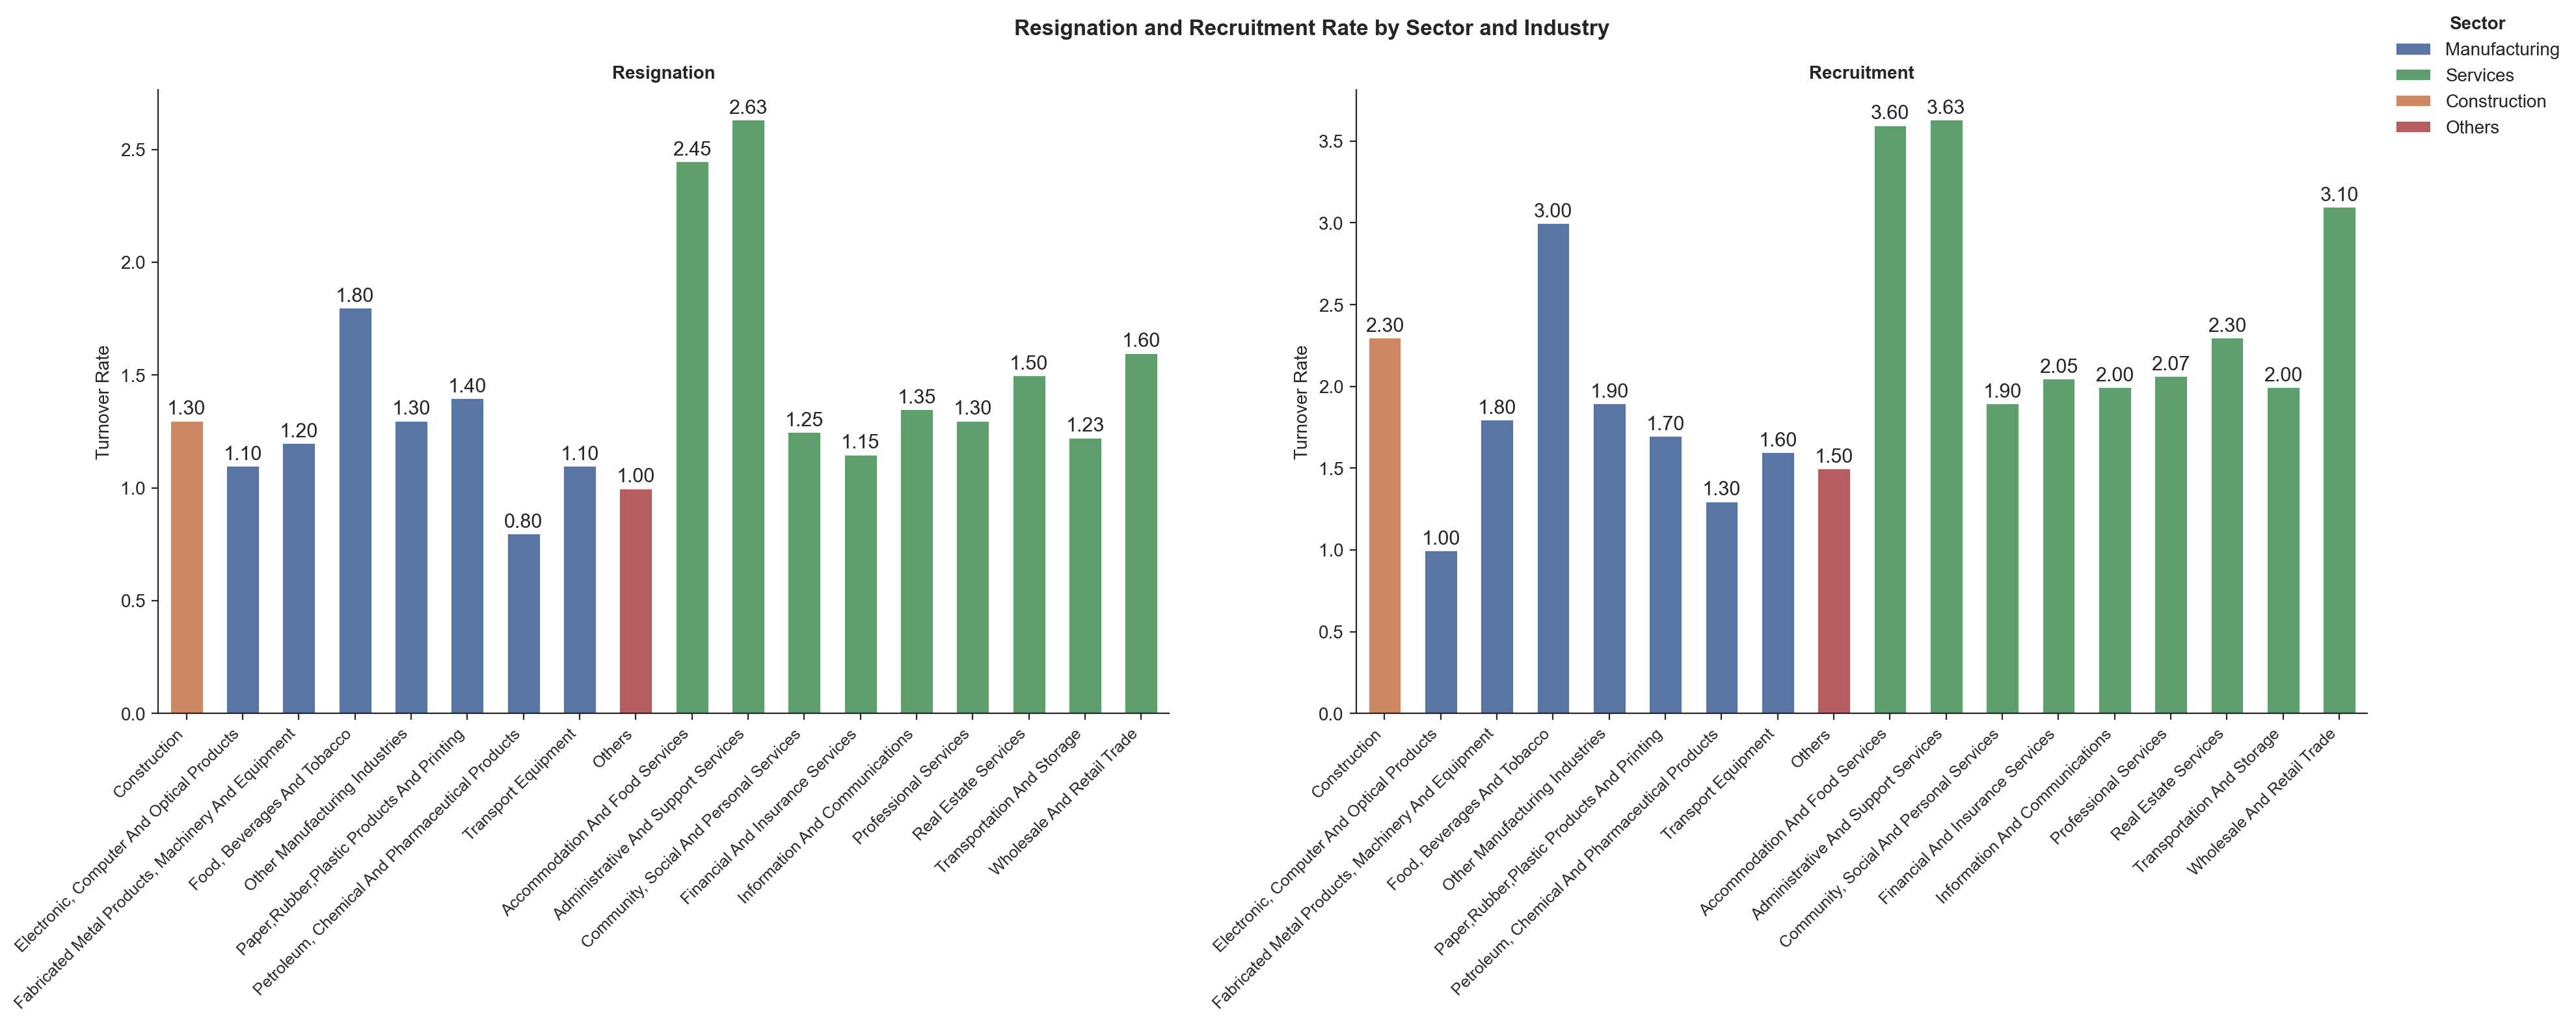

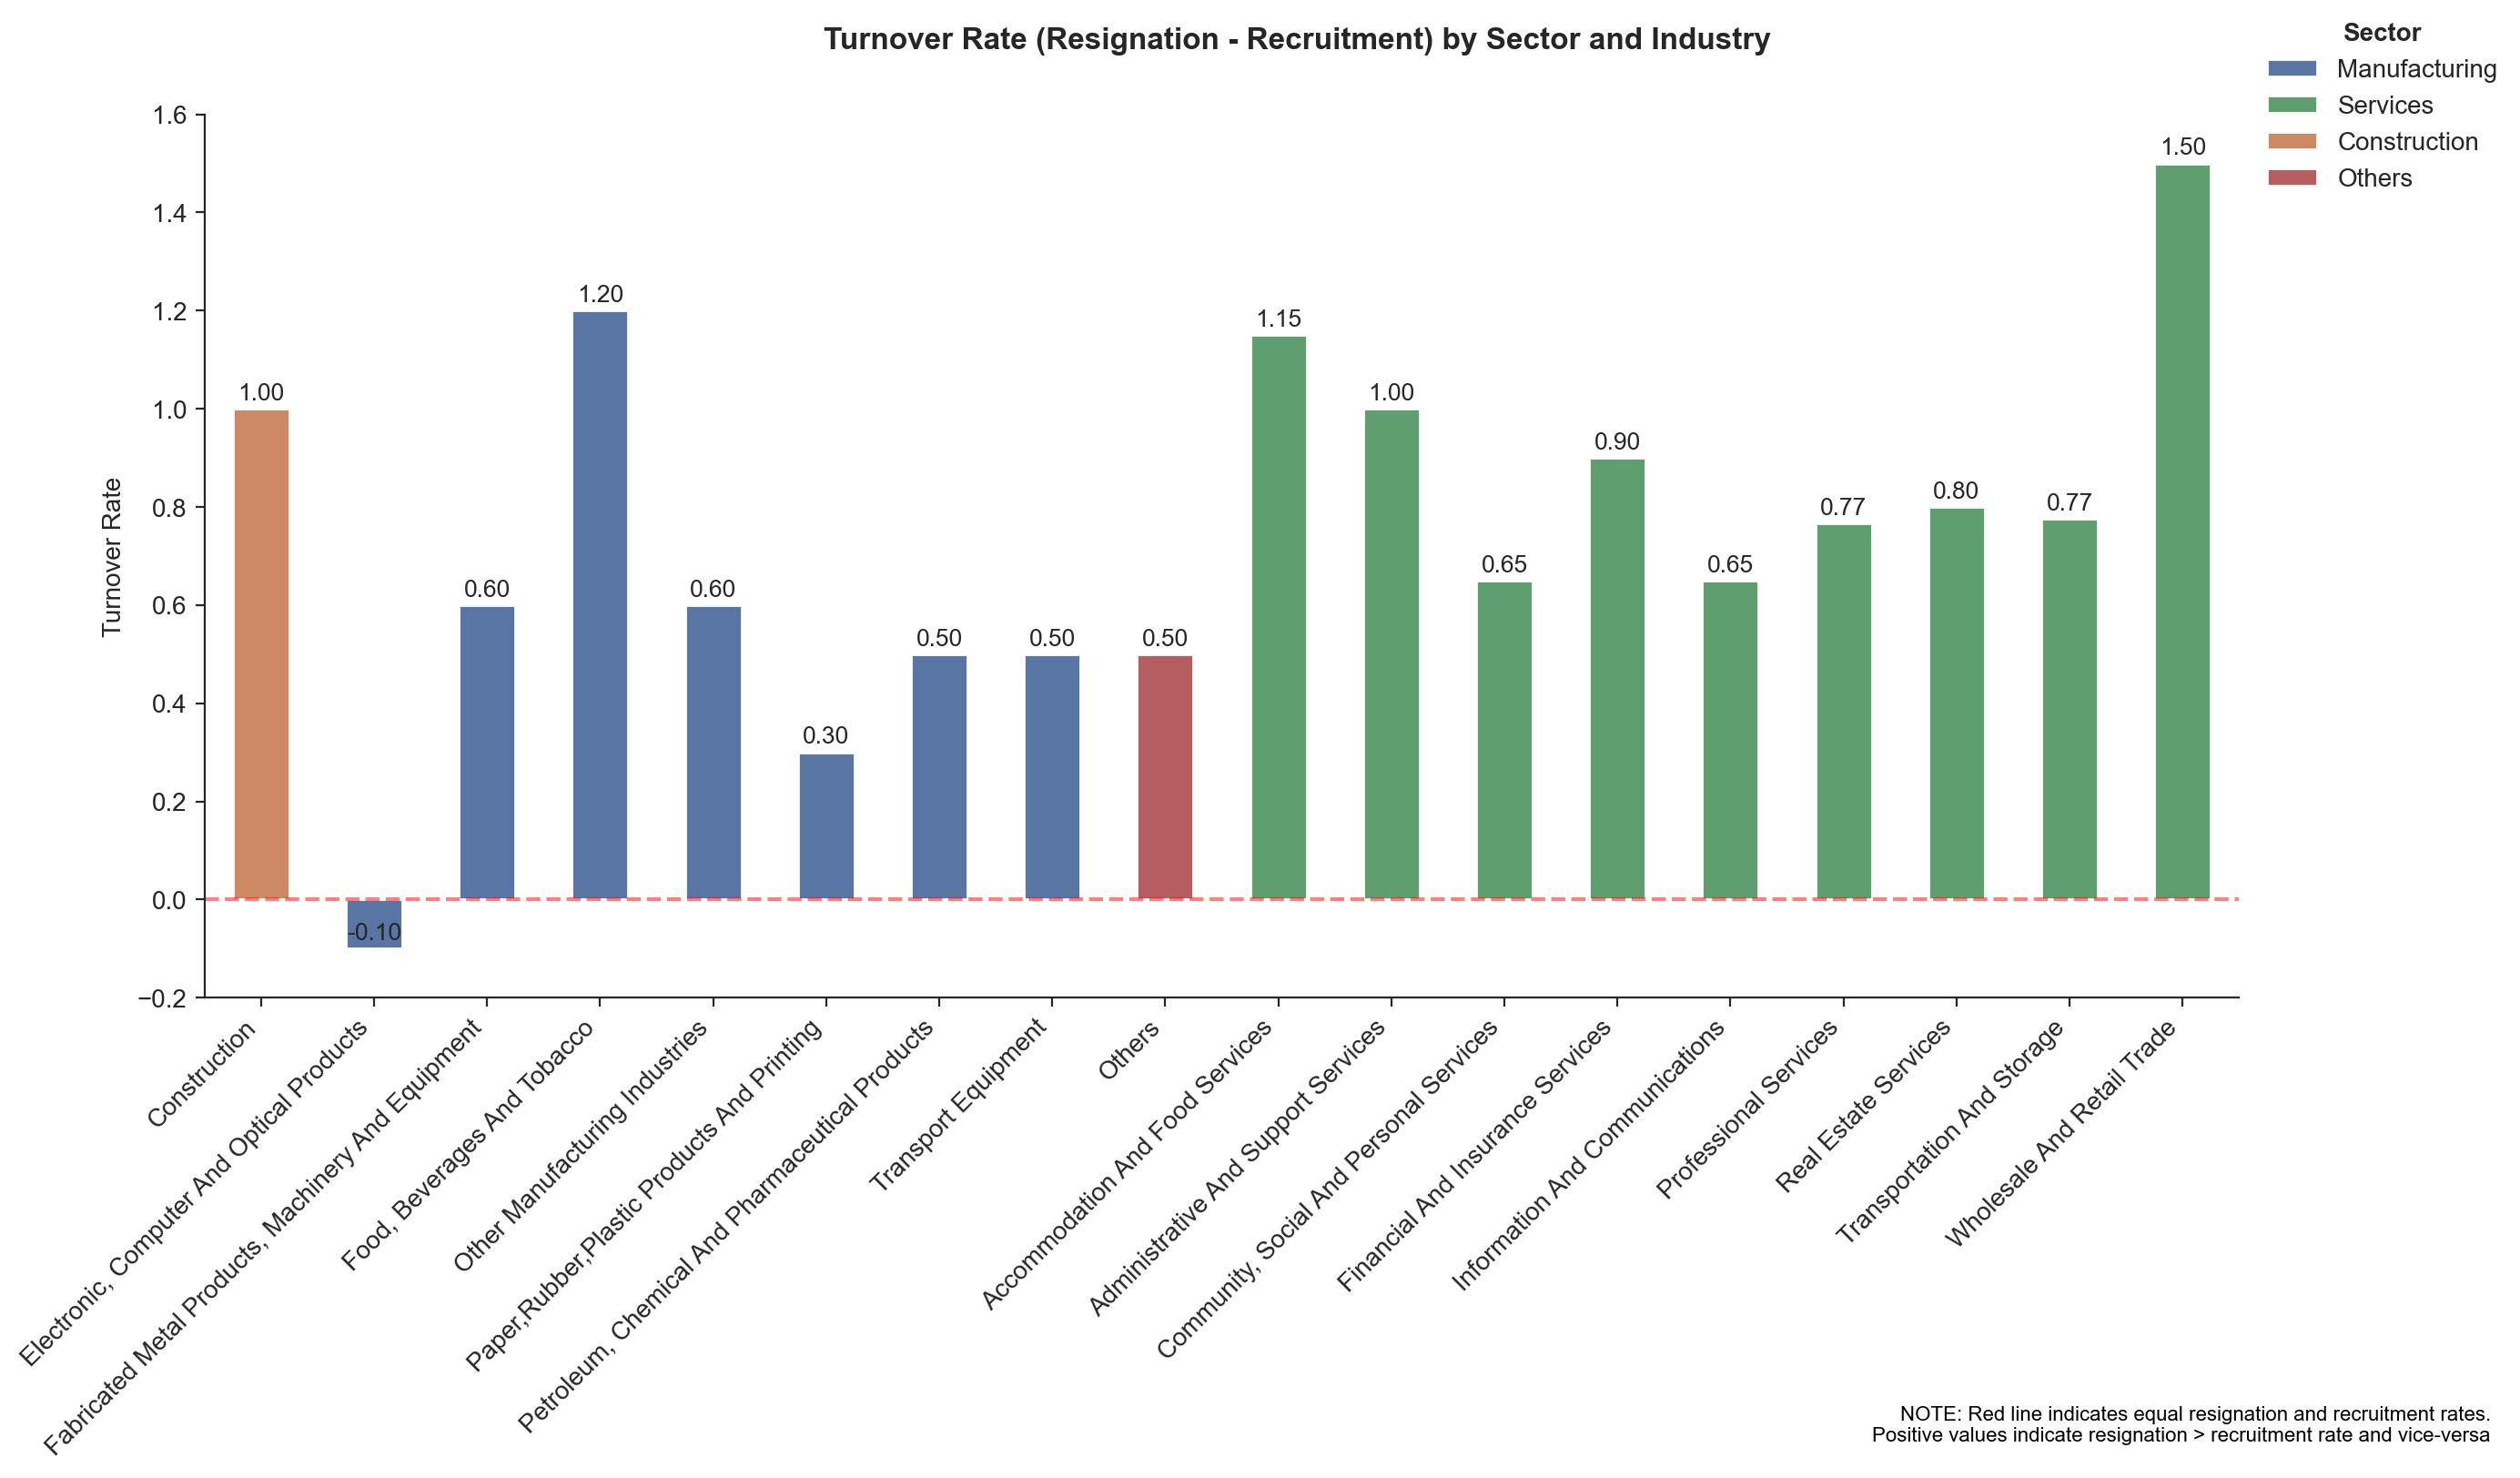

In [6]:
# Exract latest employee turnover data from 2023
query = '''
SELECT * FROM TURNOVER
WHERE YEAR = 2023 AND OCCUPATION = 'total' AND INDUSTRY3 <> 'total'
'''
turnover = pd.read_sql(query, con)

# Data cleaning and preparation
turnover['INDUSTRY1'] = turnover['INDUSTRY1'].str.title() # Convert industry names to title case for presentation
turnover['INDUSTRY2'] = turnover['INDUSTRY2'].str.title() # Convert industry names to title case for presentation
turnover['TURNOVER_RATE'] = turnover['RECRUITMENT'] - turnover['RESIGNATION']

turnover_group = turnover.groupby(['YEAR', 'INDUSTRY1', 'INDUSTRY2']).agg(RECRUITMENT_MEAN = ('RECRUITMENT', 'mean'),
                                                                            RESIGNATION_MEAN = ('RESIGNATION', 'mean'),
                                                                            TURNOVER_MEAN = ('TURNOVER_RATE', 'mean')).reset_index()

turnover_melt = pd.melt(turnover_group, id_vars=['INDUSTRY1', 'INDUSTRY2'], value_vars=['RECRUITMENT_MEAN', 'RESIGNATION_MEAN'], var_name='MOVEMENT', value_name='VALUE')
turnover_melt.replace({'RECRUITMENT_MEAN': 'Recruitment',
                        'RESIGNATION_MEAN': 'Resignation'}, inplace=True)

# Correlation between resignation and recruitment
recruit = turnover_melt[turnover_melt['MOVEMENT'] == 'Recruitment']['VALUE']
resign = turnover_melt[turnover_melt['MOVEMENT'] == 'Resignation']['VALUE']

print(f"Correlation between recruitment and resignation: {round(scipy.stats.pearsonr(recruit, resign)[0],3)} (p = {scipy.stats.pearsonr(recruit, resign)[1]:.3f})")
print('\n')

print('================= TOP 5 INDUSTRIES WITH HIGHEST RESIGNATION, RECRUITMENT & TURNOVER RATES =================')
print(turnover_group[['INDUSTRY1', 'INDUSTRY2', 'RESIGNATION_MEAN', 'RECRUITMENT_MEAN', 'TURNOVER_MEAN']].nlargest(columns=['RESIGNATION_MEAN', 'RECRUITMENT_MEAN', 'TURNOVER_MEAN'], n=5).reset_index(drop=True))

c = sns.color_palette('deep')
reordered_palette = [c[0], c[2], c[1], c[3]]

# Plot resignation and recruitment trend by industry/sector
sns.set_style('ticks')
ax = sns.catplot(x='INDUSTRY2', y='VALUE', hue='INDUSTRY1', col='MOVEMENT', data=turnover_melt, kind='bar', errorbar=None,
    hue_order = ['Manufacturing', 'Services', 'Construction', 'Others'], col_order = ['Resignation', 'Recruitment'], height=6, aspect=1.5, width=0.6,
    palette = reordered_palette, dodge=False, sharey=False, sharex=False)

ax.fig.suptitle('Resignation and Recruitment Rate by Sector and Industry', fontweight='bold')
ax.set(xlabel='', ylabel='Turnover Rate')
ax.set_xticklabels(rotation=45, ha='right', fontsize=9)
ax._legend.set_title(title='Sector', prop={'weight': 'bold'})
sns.move_legend(ax, loc='upper right')
ax.set_titles(col_template='{col_name}', fontweight='bold')

plt.subplots_adjust(top=0.89)

for c in ax.axes.flat:
    for i in c.patches:
        if i.get_height() != 0:
            c.annotate(format(i.get_height(), '.2f'), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='center',
                xytext=(0,6), textcoords = 'offset points', fontsize=11)

plt.show()

# Plot turnover rate (resignation-recruitment) by industry/sector
sns.set_style('ticks')
ax = sns.catplot(x='INDUSTRY2', y='TURNOVER_MEAN', hue='INDUSTRY1', data=turnover_group, kind='bar', errorbar=None,
    hue_order = ['Manufacturing', 'Services', 'Construction', 'Others'], height=6, aspect=2, width=0.5,
    palette = reordered_palette, dodge=False)

ax.fig.suptitle('Turnover Rate (Resignation - Recruitment) by Sector and Industry', fontweight='bold')
ax.set(xlabel='', ylabel='Turnover Rate', ylim=(-0.2, 1.6))
ax.set_xticklabels(rotation=45, ha='right')
ax._legend.set_title(title='Sector', prop={'weight': 'bold'})
sns.move_legend(ax, loc='upper right')

ax.axes[0][0].axhline(0, color='red', ls='--', alpha=0.5)
plt.subplots_adjust(top=0.9)

for i in ax.ax.patches:
    if i.get_height() != 0:
        ax.ax.annotate(format(i.get_height(), '.2f'), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='center',
            xytext=(0,6), textcoords = 'offset points', fontsize=9.5)

ax.fig.text(0.99, -0.3, 'NOTE: Red line indicates equal resignation and recruitment rates.\nPositive values indicate resignation > recruitment rate and vice-versa',
    ha='right', va='center', fontsize=8, color='black')

plt.show()

<u><b>Analysis</b></u><br>
Besides evaluating job security based on retrenchment data, job-seekers can also look for opportunities within industries based on industry turnover rates (i.e., recruitment > resignation) while concurrently assessing potential job satisfaction as well. Using the latest resignation and recruitment data from 2023, the resignation and recruitment rates for each industry were plotted for job-seekers to get a sensing of labour-management relations as well as job opportunties.


<u><b>Insights</b></u><br>
Generally, there is a strong positive correlation between recruitment and resignations in the labour market (<i>r</i> = 0.914, <i>p</i> = 0.000 < 0.05)

Resignations are most frequent in the services sector, particularly in Accommodation & Food Services, and Administrative & Support Services industries, suggesting low job satisfaction.
In the manufacturing sector, the Food, Beverages & Tobacco industry has the highest resignation rate. However, industries with high resignation rates also tend to have high recruitment rates, with the Accommodation & Food Services, Administrative & Support Services, and Food, Beverages & Tobacco industries leading in both.

When considering overall turnover, the Wholesale & Retail Trade industry stands out with the highest positive turnover due to high recruitment and low resignation rates, indicating good job satisfaction and industry growth. Although this sector also shows the highest retrenchment rates, this may hint towards organisational restructuring aimed at optimising future opportunities by eliminating redundant positions and focusing on more strategic roles.

Therefore, assessing both recruitment and resignation rates vis-a-vis retrenchment trends is essential for a comprehensive understanding of the labour market in terms of job security, opportunities, and satisfaction for job-seekers.

<u><b>Note</b></u><br>
It is important to note, however, that positive turnover (i.e., high recruitment) not entirely indicative of residential employment. Job-seekers should be mindful of prevailing market conditions and labour regulations/laws which are not considered in this analysis.


## Wage Comparison Across Industries <a id = '2_4'></a>

=========================================== TOP INDUSTRY FROM EACH OCCUPATION GROUP ===========================================
   RANK_NO                                         OCCUPATION                                      INDUSTRY1  INDUSTRY_MEAN_WAGE
0        1               Professionals, Managers & Executives  Telecommunications, Broadcasting & Publishing            13647.67
1        1              Associate Professionals & Technicians  Petroleum, Chemical & Pharmaceutical Products             6289.00
2        1  Production & Transport Operators, Cleaners & L...  Petroleum, Chemical & Pharmaceutical Products             5680.50
3        1                  Clerical, Service & Sales Workers  Petroleum, Chemical & Pharmaceutical Products             4729.67


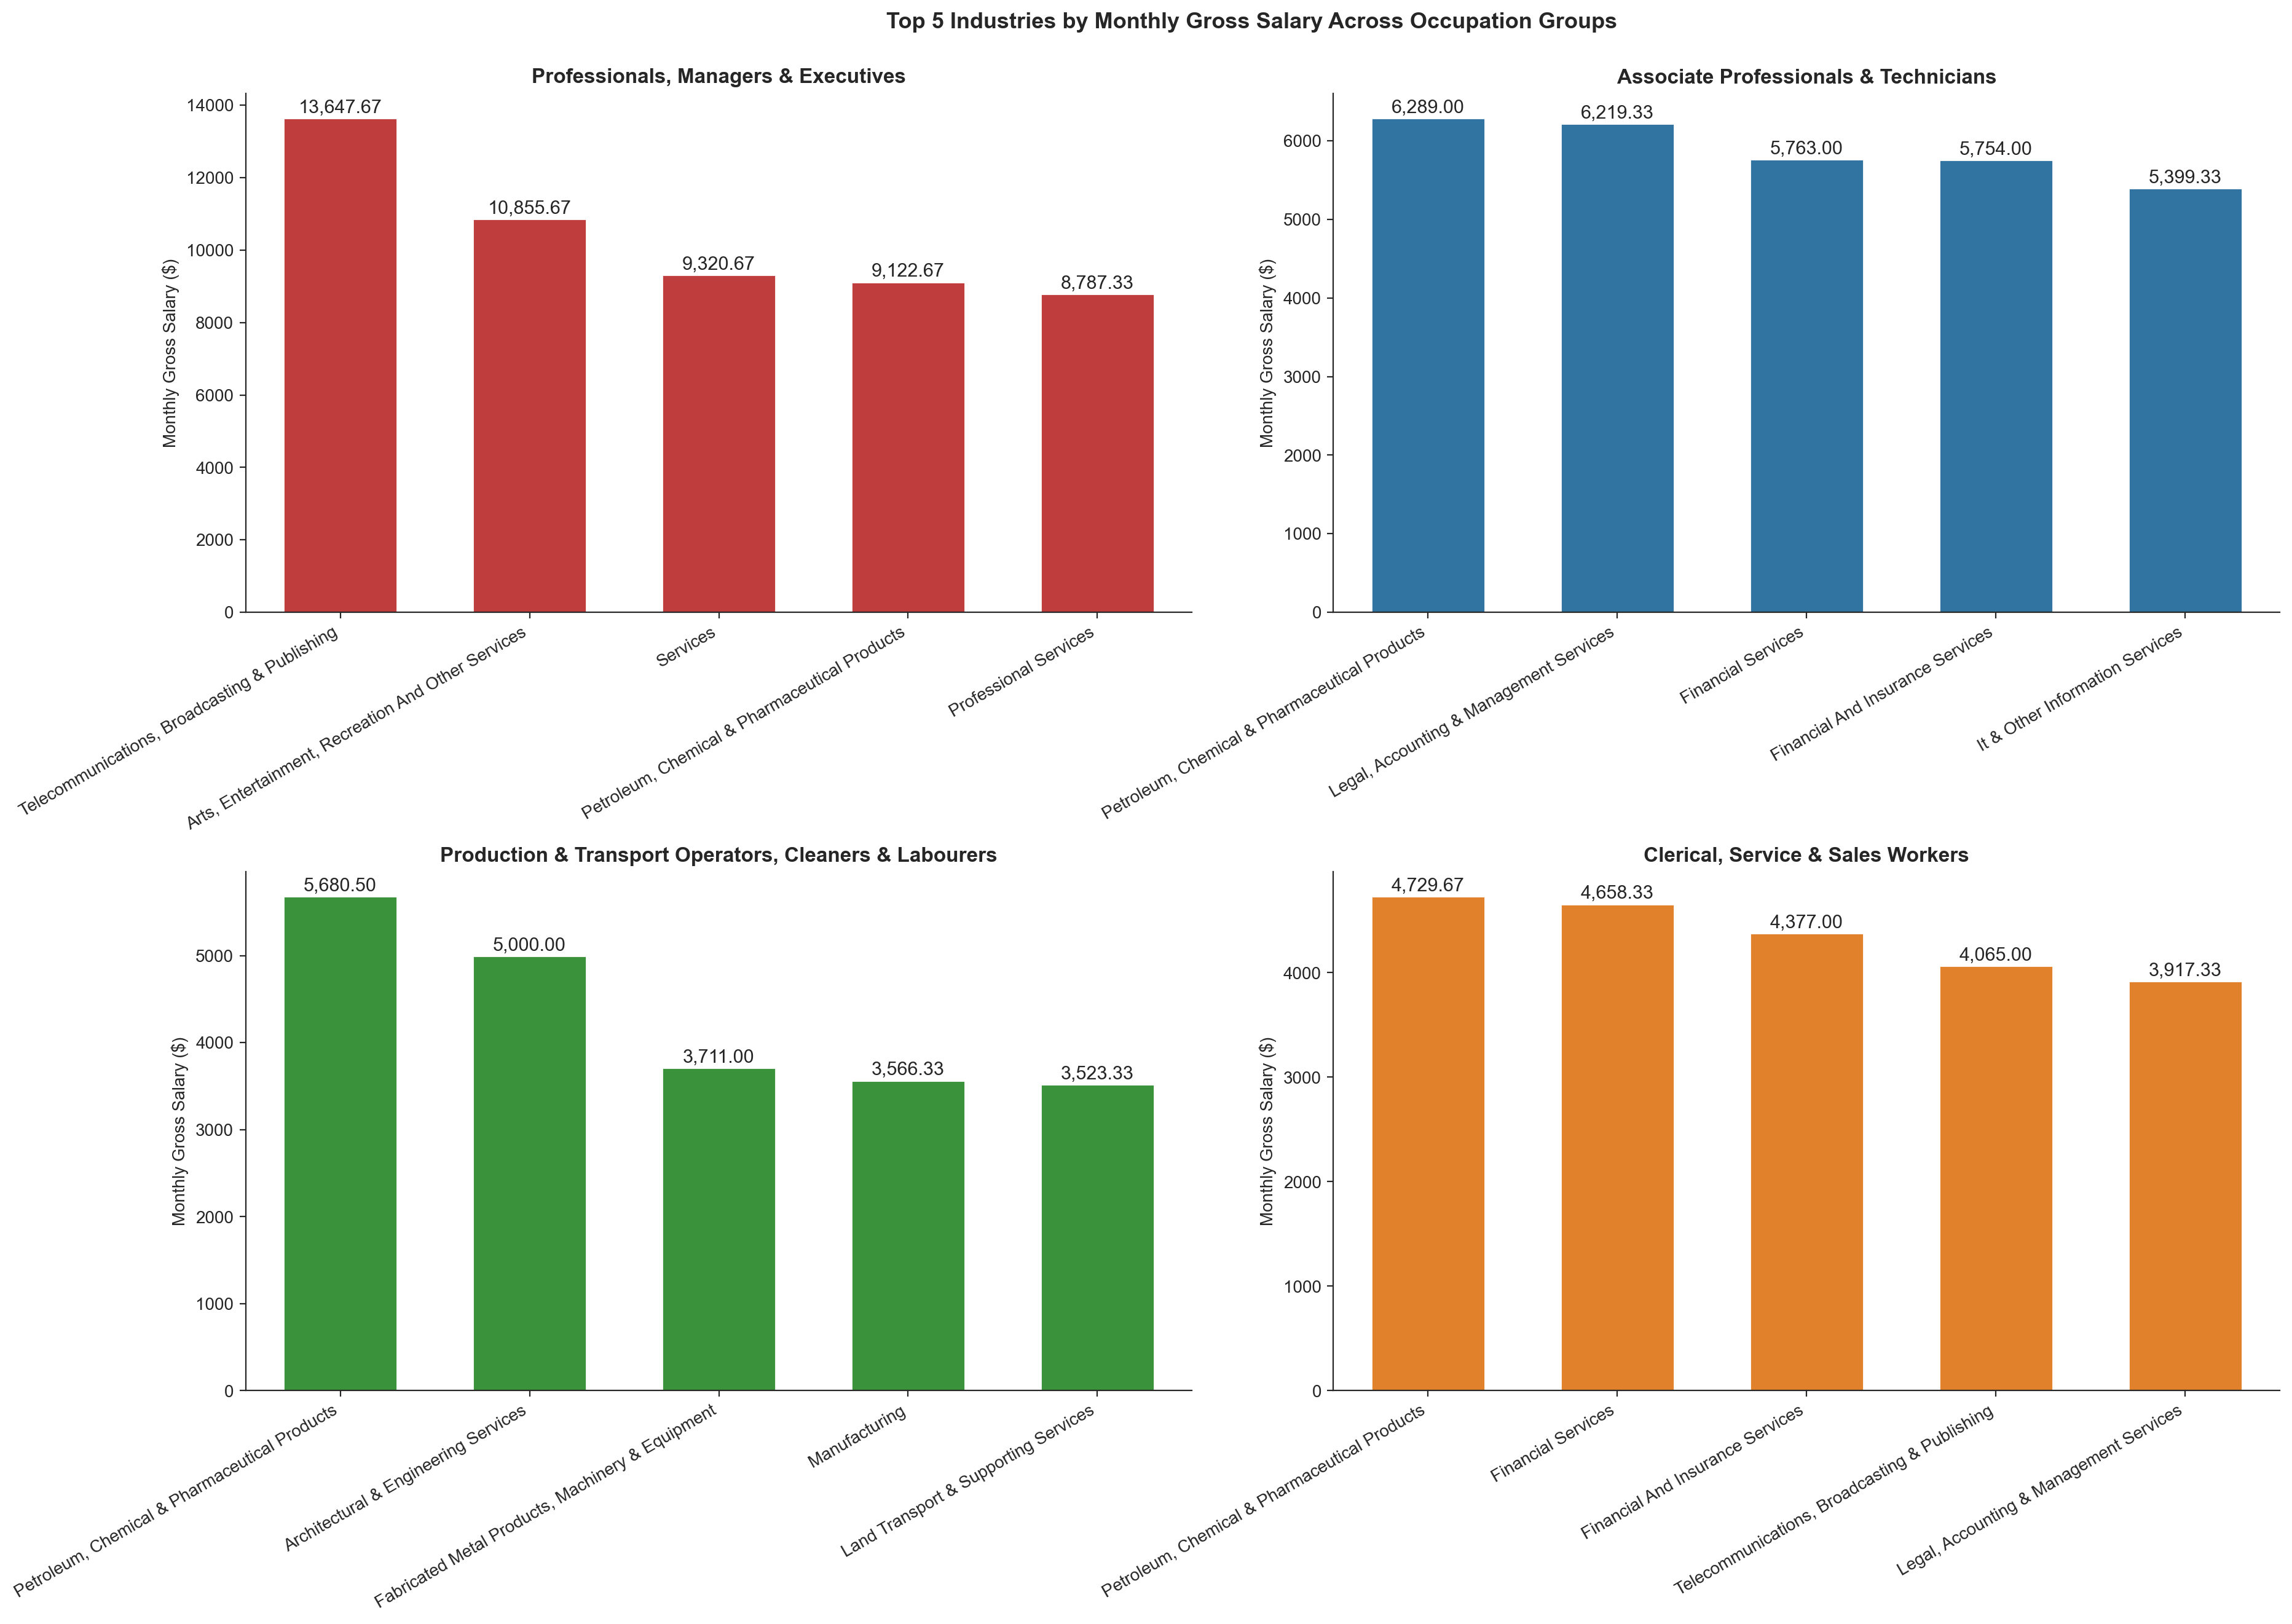

=============================================== JOB-SPECIFIC INFORMATION FOR TOP PAYING INDUSTRY ACROSS DIFFERENT OCCUPATION GROUPS ===============================================
Further details on the job descriptions of the top industry with the highest average income in each job occupation group are as follows:


*******************************ASSOCIATE PROFESSIONALS & TECHNICIANS********************************
Industry: Petroleum, Chemical & Pharmaceutical Products
Job Description: Chemical Engineering Technician
Monthly Gross Income: $6,455.00


Industry: Petroleum, Chemical & Pharmaceutical Products
Job Description: Manufacturing Engineering Technician
Monthly Gross Income: $4,889.00


Industry: Petroleum, Chemical & Pharmaceutical Products
Job Description: Mechanical Engineering Technicians (Excluding Transport And Vehicle Engineering Technicians)
Monthly Gross Income: $7,523.00


*********************************CLERICAL, SERVICE & SALES WORKERS*******************************

In [7]:
# Extract 2022 wage data
query = '''
SELECT T2.*
FROM (
    SELECT ROW_NUMBER() OVER(PARTITION BY OCCUPATION ORDER BY INDUSTRY_MEAN_WAGE DESC) AS RANK_NO, T1.*
    FROM (
        SELECT OCCUPATION, INDUSTRY1, ROUND(AVG(MTHLY_GROSS), 2) AS INDUSTRY_MEAN_WAGE 
        FROM WAGES
        WHERE YEAR = 2022
        GROUP BY OCCUPATION, INDUSTRY1
    ) T1
) T2
WHERE RANK_NO <= 5
'''
wages = pd.read_sql(query, con)

# Extract wage dataframe with occupation description (ungrouped)
query = '''
SELECT OCCUPATION, INDUSTRY1, OCCUPATION_DESC, MTHLY_GROSS
FROM WAGES
WHERE YEAR = 2022
'''
wages_occ = pd.read_sql(query, con)
wages_occ = pd.merge(wages[wages['RANK_NO'] <= 5], wages_occ, on=['OCCUPATION', 'INDUSTRY1'], how='left')[['RANK_NO', 'OCCUPATION', 'INDUSTRY1', 'OCCUPATION_DESC', 'MTHLY_GROSS', 'INDUSTRY_MEAN_WAGE']]

# Data cleaning
wages['OCCUPATION'] = wages['OCCUPATION'].str.title()
wages['INDUSTRY1'] = wages['INDUSTRY1'].str.title()

print('================= TOP INDUSTRY FROM EACH OCCUPATION GROUP =================')
print(wages[wages['RANK_NO'] == 1].sort_values(by ='INDUSTRY_MEAN_WAGE', ascending=False).reset_index(drop=True))

# Plot wages by industry and occupation group
sns.set_style('ticks')
ax = sns.catplot(x='INDUSTRY1', y='INDUSTRY_MEAN_WAGE', hue='OCCUPATION', data=wages, kind='bar', errorbar=None,
    col='OCCUPATION', col_wrap=2, col_order = ['Professionals, Managers & Executives', 'Associate Professionals & Technicians', 'Production & Transport Operators, Cleaners & Labourers', 'Clerical, Service & Sales Workers'],
    height=6, aspect=1.5, width=0.6,
    sharex=False, sharey=False, legend=False)

plt.subplots_adjust(hspace=0.5, top=0.925)

ax.fig.suptitle('Top 5 Industries by Monthly Gross Salary Across Occupation Groups', fontweight='bold', size=13)
ax.set(xlabel='', ylabel='Monthly Gross Salary ($)')
ax.set_xticklabels(rotation=30, ha='right', fontsize=10)
ax.set_titles(col_template='{col_name}', fontweight='bold', size=12)

for c in ax.axes.flat:
    for i in c.patches:
        c.annotate(format(i.get_height(), ',.2f'), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='center',
            xytext=(0,6), textcoords = 'offset points', fontsize=11)

plt.show()

# Print industry and job-specific information of jobs constituting the top industry across occupation groups
print('================= JOB-SPECIFIC INFORMATION FOR TOP PAYING INDUSTRY ACROSS DIFFERENT OCCUPATION GROUPS =================')
print('Further details on the job descriptions of the top industry with the highest average income in each job occupation group are as follows:')
print('\n')

for occ in wages_occ['OCCUPATION'].unique():
    print(f"{occ.upper():*^100}")
    df_temp = wages_occ[(wages_occ['RANK_NO'] == 1) & (wages_occ['OCCUPATION'] == occ)]
    for index, row in df_temp.iterrows():
        industry = row['INDUSTRY1'].title()
        occ_desc = row['OCCUPATION_DESC'].title()
        mthly_gross = row['MTHLY_GROSS']
        print(f'Industry: {industry}')
        print(f'Job Description: {occ_desc}')
        print(f'Monthly Gross Income: ${mthly_gross:,.2f}')
        print('\n')

<u><b>Analysis</b></u><br>
Another key consideration for job-seekers is the compensation associated with different roles. By analysing the latest wage data from 2022, the wages of 4 occupation groups were  compared across industries. This analysis identifies the top 5 highest-paying industries in each occupation group, offering job-seekers insights into their financial standing and  assisting them in making informed decisions about their career aspirations and goals.


<u><b>Insights</b></u><br>
Based on the 2022 wage data from MOM, PMEs have the highest wage across all occupation groups, with the higest coming from the Telecommunications, Broadcasting & Publishing industry
with a mean monthly industry wage of $13,647.67. For the other three occupation groups, the industry with the highest mean industry wage is the Petroleum, Chemical & Pharmaceutical Products industry.

## Weekly Hours Worked Across Industries <a id = '2_5'></a>

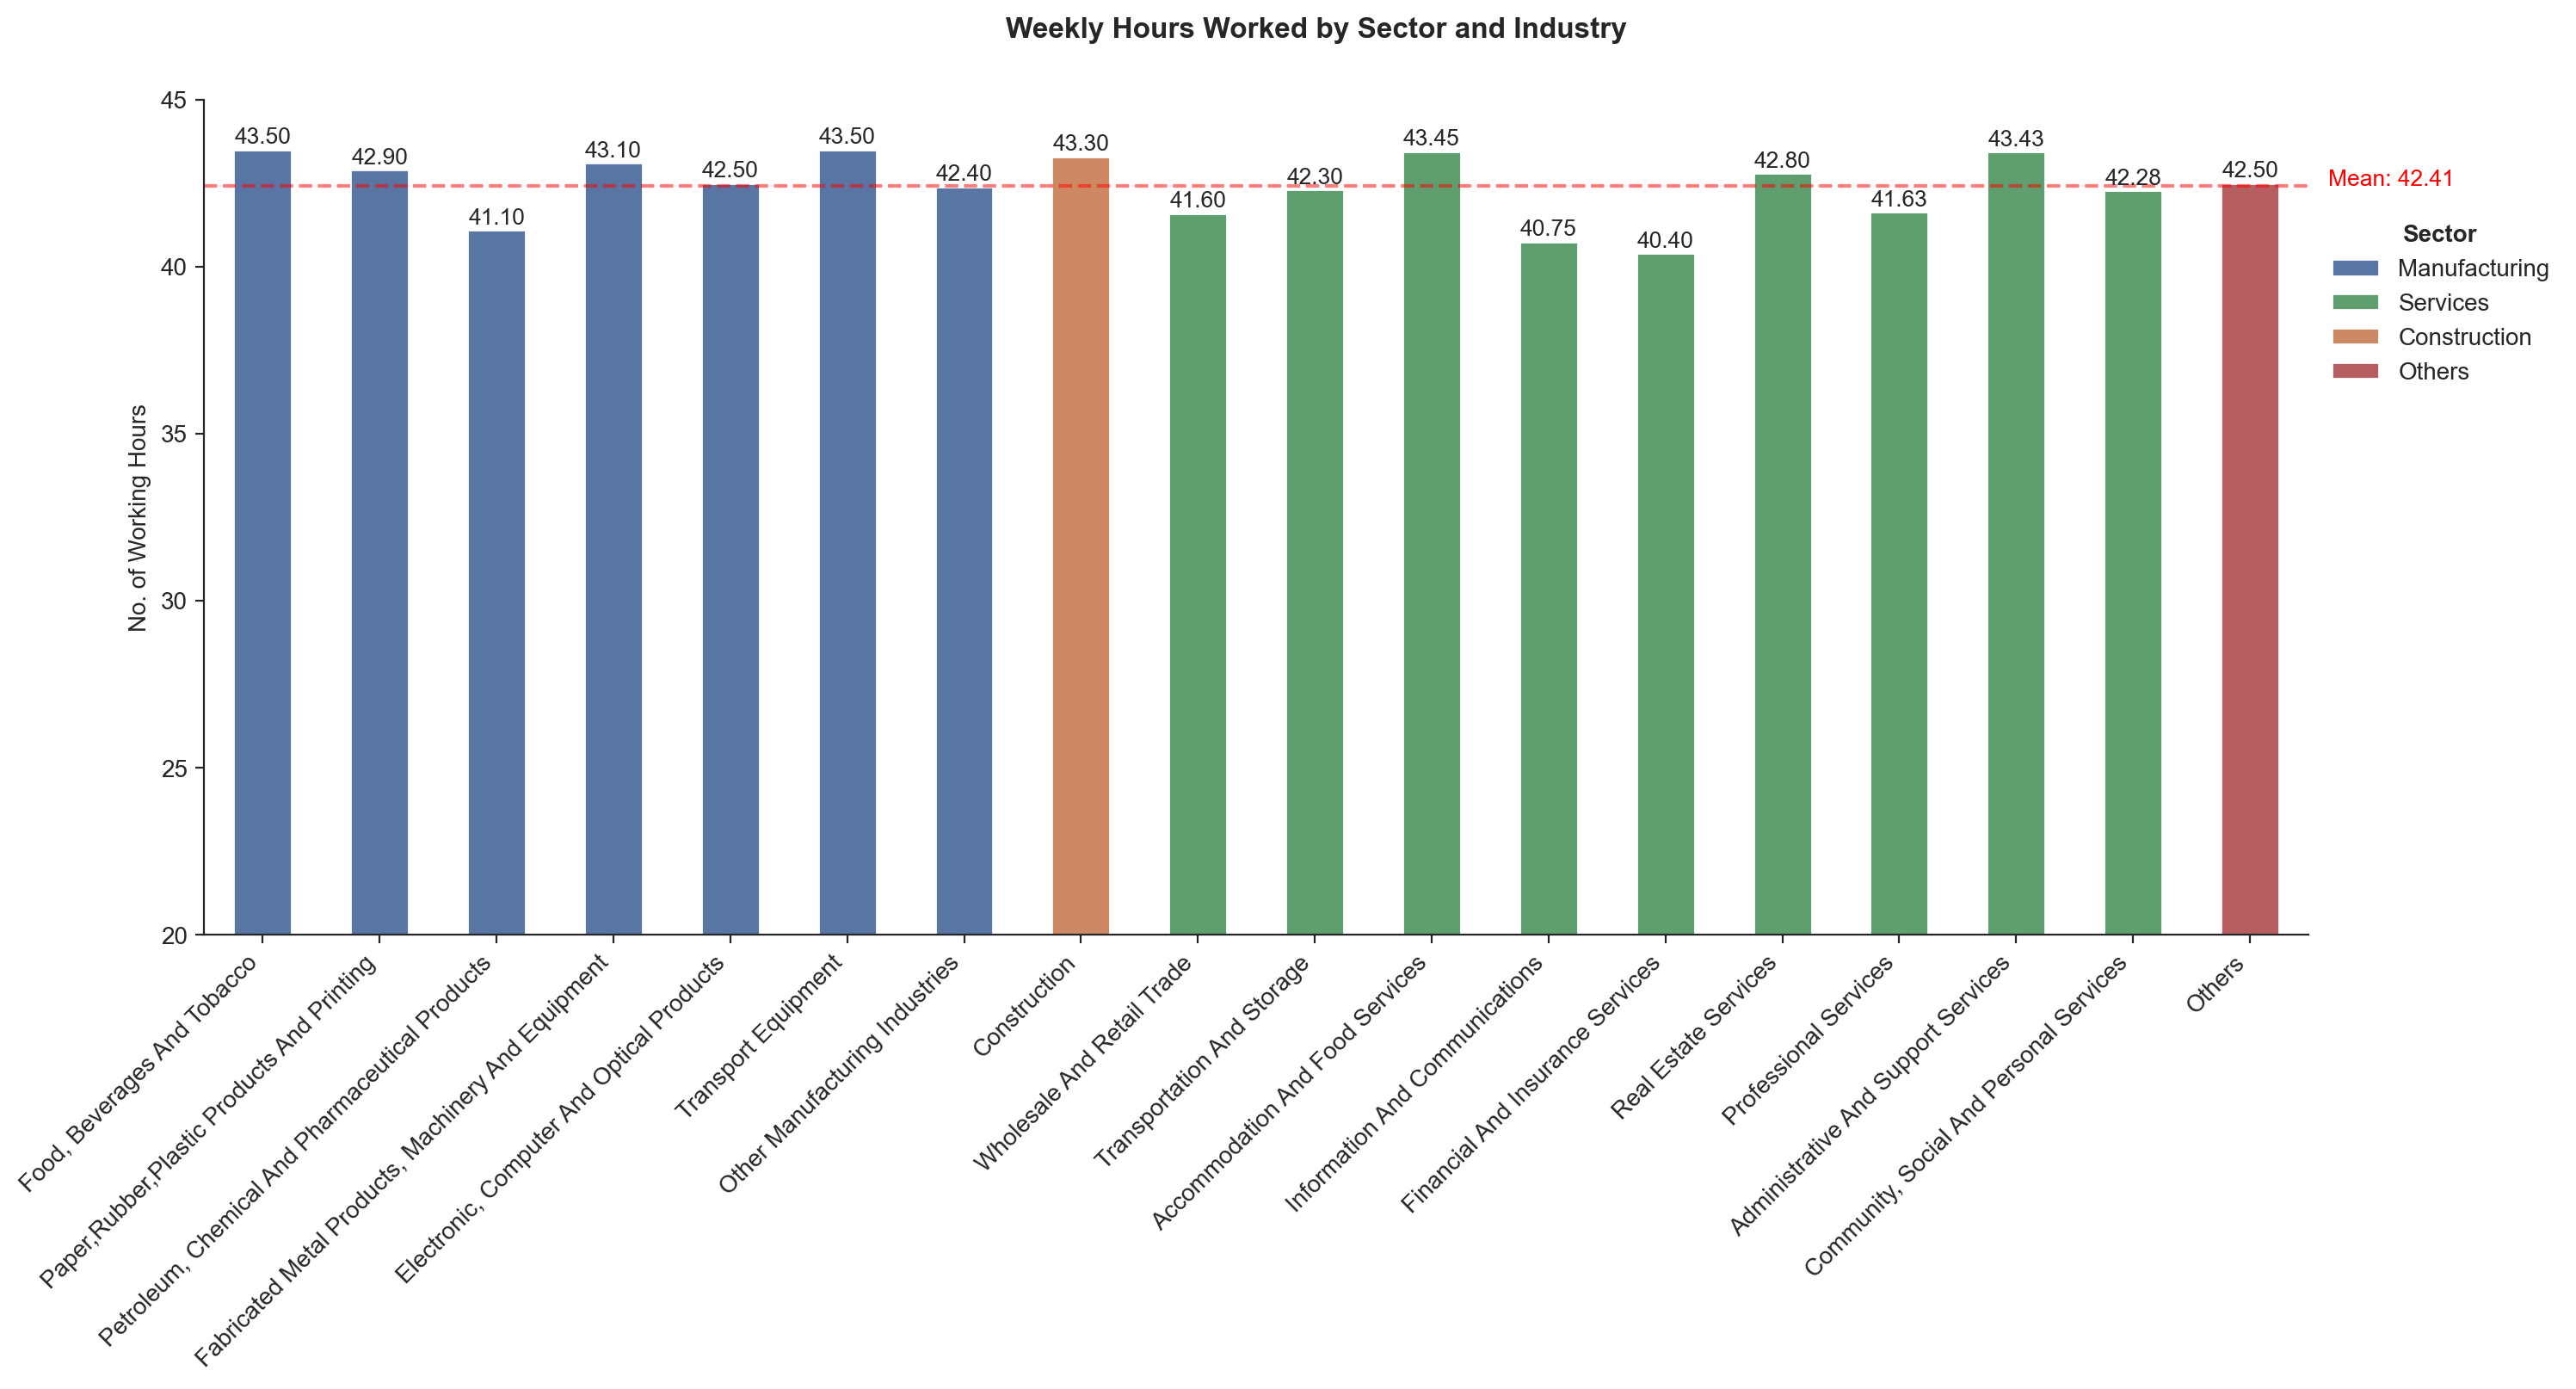

In [8]:
# Extract 2023 weekly hours worked data
query = '''
SELECT INDUSTRY1, INDUSTRY2, AVG(STANDARD_HOURS) AS STANDARD_HOURS
FROM WEEKLY_HOURS
WHERE YEAR = 2023 AND EMPLOYMENT_NATURE = 'full-time'
GROUP BY INDUSTRY1, INDUSTRY2
'''
weekly_hours = pd.read_sql(query, con)

# Data cleaning
weekly_hours['INDUSTRY1'] = weekly_hours['INDUSTRY1'].str.title()
weekly_hours['INDUSTRY2'] = weekly_hours['INDUSTRY2'].str.title()

# Plot turnover rate (resignation-recruitment) by industry/sector
sns.set_style('ticks')

c = sns.color_palette('deep')
reordered_palette = [c[0], c[2], c[1], c[3]]

ax = sns.catplot(x='INDUSTRY2', y='STANDARD_HOURS', hue='INDUSTRY1', data=weekly_hours, kind='bar', errorbar=None,
    hue_order = ['Manufacturing', 'Services', 'Construction', 'Others'], height=6, aspect=2.2, width=0.5,
    palette = reordered_palette, dodge=False)

ax.fig.suptitle('Weekly Hours Worked by Sector and Industry', fontweight='bold')
plt.subplots_adjust(top=0.9)
plt.xlabel('')
plt.ylabel('No. of Working Hours')
plt.xticks(rotation=45, ha='right', size=10)
plt.ylim(20, 45)
plt.axhline(weekly_hours['STANDARD_HOURS'].mean(), color='red', linestyle='--', alpha=0.5)
ax._legend.set_title(title='Sector', prop={'weight': 'bold'})
sns.move_legend(ax, loc='upper right', bbox_to_anchor=(1,0.8))

for i in ax.ax.patches:
    if i.get_height() != 0:
        ax.ax.annotate(format(i.get_height(), '.2f'), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='center',
            xytext=(0,5), textcoords = 'offset points', fontsize=9.5)

plt.text(len(weekly_hours)+0.75, weekly_hours['STANDARD_HOURS'].mean(), f"Mean: {weekly_hours['STANDARD_HOURS'].mean():.2f}", 
         color='red', ha='right', fontsize=9.5)

plt.show()

<u><b>Analysis</b></u><br>
Apart from wages, job-seekers may also consider work-life balance, specifically in terms of weekly working hours. Here, the average number of hours worked by full-time employees (exclusive of overtime) in each industry was examined across the 18 industries, providing insights for job-seekers to factor into their job search decisions.


<u><b>Insights</b></u><br>
The working hours across industries tend to be fairly consistent, averaging around 42.41 hours per week. Notably, the Information and Communications industry, along with the Financial and Insurance Services industry, has some of the shortest working hours, about 2 hours less than the average. In contrast, industries such as Transport Equipment, Construction, and Administrative and Support Services generally require employees to work approximately 1 hour more than the average.

Job-seekers may want to take these differences in working hours into account when seeking a job that offers a good work-life balance and overall satisfaction.

## Leave Benefits by Industry <a id = '2_6'></a>

In [9]:
# Extract 2022 annual leave data
query = '''
SELECT * FROM ANNUAL_LEAVE
WHERE YEAR = 2022
'''
annual_leave = pd.read_sql(query, con)

# Data cleaning
annual_leave_pivot = pd.pivot(data=annual_leave, index=['INDUSTRY1', 'INDUSTRY2', 'INDUSTRY3'], columns='ANNUAL_LEAVE', values='DISTRIBUTION').reset_index()
annual_leave_pivot['total'] = annual_leave_pivot['14 days & below'] + annual_leave_pivot['15 to 21 days'] + annual_leave_pivot['over 21 days']
annual_leave_pivot.dropna(subset='total', inplace=True)

annual_leave_melt = annual_leave_pivot.melt(id_vars=['INDUSTRY1', 'INDUSTRY2'], value_vars=['14 days & below', '15 to 21 days', 'over 21 days'], var_name='ANNUAL_LEAVE').groupby(['INDUSTRY1', 'INDUSTRY2', 'ANNUAL_LEAVE'])['value'].mean().reset_index()
annual_leave_pivot_cleaned = pd.pivot(data=annual_leave_melt, index=['INDUSTRY1', 'INDUSTRY2'], columns='ANNUAL_LEAVE', values='value').reset_index()

# Extract 2022 other leave data
query = '''
SELECT * FROM OTHER_LEAVE
WHERE YEAR = 2022
'''
other_leave = pd.read_sql(query, con)

# Data cleaning
other_leave.fillna(0, inplace=True)
other_leave_melt = other_leave.melt(id_vars=['INDUSTRY1', 'INDUSTRY2', 'INDUSTRY3'], 
                                    value_vars=['COMPASSIONATE_LEAVE', 'MARRIAGE_LEAVE', 'UNPAID_LEAVE_MORETHAN_1MTH', 'UNPAID_LEAVE_LESSTHAN_1MTH', 'STUDY_LEAVE', 'CHILD_SICK_LEAVE', 'PARENT_CARE_LEAVE'],
                                    var_name='LEAVE_TYPE')
other_leave_group = other_leave_melt.groupby(['INDUSTRY1', 'INDUSTRY2', 'LEAVE_TYPE'])['value'].mean().reset_index()
other_leave_pivot_cleaned = pd.pivot(data=other_leave_group, index=['INDUSTRY1', 'INDUSTRY2'], columns='LEAVE_TYPE', values='value').reset_index()

# Update join keys in other_leave_pivot_cleaned as they are slightly different from annual_leave table
other_leave_pivot_cleaned['INDUSTRY2'].replace('electronic and computer products', 'electronic, computer and optical products', inplace=True)
other_leave_pivot_cleaned['INDUSTRY2'].replace('fabricated metal products and machinery', 'fabricated metal products, machinery and equipment', inplace=True)

# Merge annual_leave and other_leave for analaysis
df = pd.merge(annual_leave_pivot_cleaned, other_leave_pivot_cleaned, on='INDUSTRY2', how='left', suffixes=('', '_OL'))
df.drop(columns=['INDUSTRY1_OL'], inplace=True)

# Inspect merged df
print('================= INSPECT MERGED DATA =================')
print(df.head())

======================================================================================= INSPECT MERGED DATA =====================================================================================================================================================
       INDUSTRY1                                          INDUSTRY2  14 days & below  15 to 21 days  over 21 days  CHILD_SICK_LEAVE  COMPASSIONATE_LEAVE  MARRIAGE_LEAVE  PARENT_CARE_LEAVE  STUDY_LEAVE  UNPAID_LEAVE_LESSTHAN_1MTH  UNPAID_LEAVE_MORETHAN_1MTH
0   construction                                       construction             90.6            8.7           0.7              50.9                 78.2            60.2               30.0         41.9                        80.7                        72.5
1  manufacturing          electronic, computer and optical products             51.7           44.8           3.6              35.1                100.0            92.5               20.9         64.9                        78.4

<u><b>Principal Component Analysis (PCA)</b></u><br>
In Singapore, there are many types of leave benefits such as annual leave, unpaid leave, marriage leave, and study leave amongst others. More often that not, job-seekers will have to evaluate the overall leave package across different industries to determine a job's attractiveness holistically. With so many types of leave to consider, comparing them across industries can be challenging. To address this, we use principal component analysis (PCA) for dimensionality reduction, which simplifies the information on different leave types across industries into two principal components (PCs) for easy comparison.

By identifying key contributors to the explained variance, job-seekers can begin to recognise industry groupings and further explore in detail the differences in leave packages based on this information.

=============== PCA EXPLAINED VARIANCE RATIO ===============
Explained variance in Principal Component 1: 0.54%
Explained variance in Principal Component 2: 0.23%
Total variance explained: 0.77%


======================================================= RELATIVE IMPORTANCE OF EACH ATTRIBUTE =======================================================
     over 21 days  CHILD_SICK_LEAVE  COMPASSIONATE_LEAVE  MARRIAGE_LEAVE  PARENT_CARE_LEAVE  STUDY_LEAVE  UNPAID_LEAVE_MORETHAN_1MTH
PC1      0.388463         -0.361631            -0.479233       -0.408096          -0.176930    -0.270580                   -0.466471
PC2      0.413065         -0.493786             0.155987        0.403161           0.021058     0.613035                   -0.149752


==================================================== ANALYSIS BASED ON TOP 2 ATTRIBUTES FROM PC1 ====================================================
The general trends and groupings derived from the contributors to each principal component (PC) can be

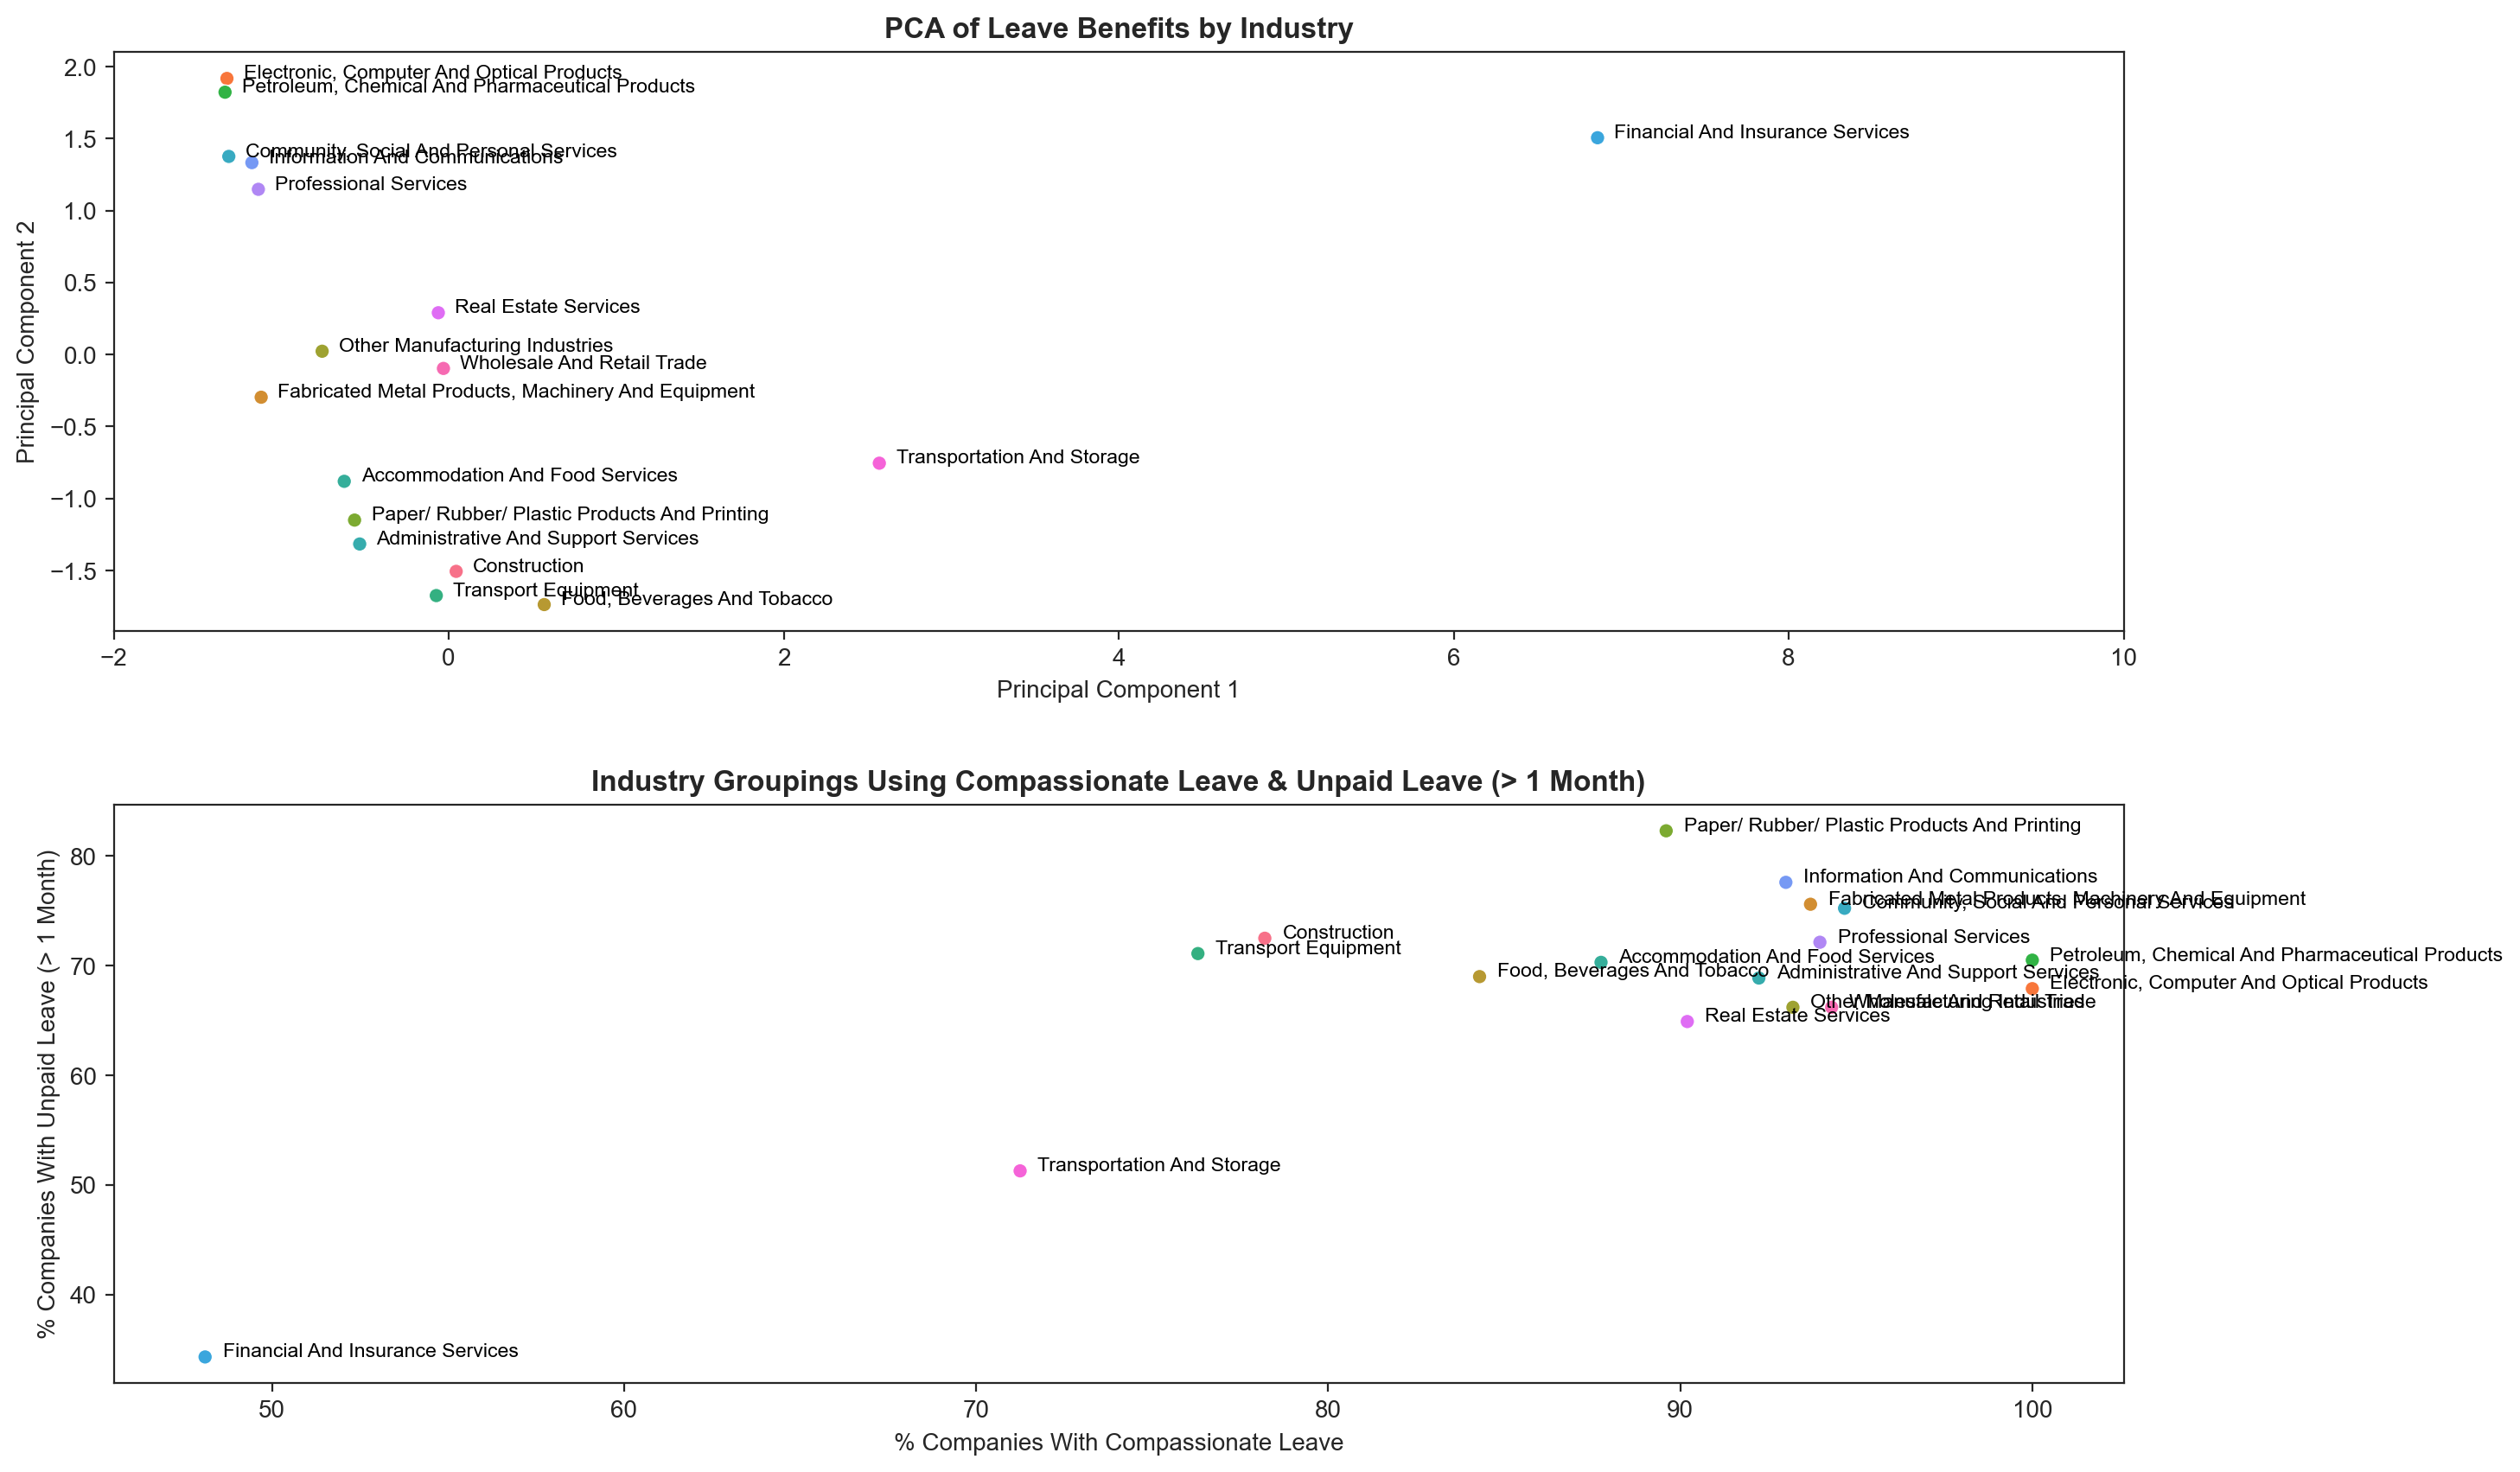

==================================================== LEAVE PACKAGE DEEP-DIVE: FINANCIAL & INSURANCE SERVICES ====================================================
                                  over 21 days  CHILD_SICK_LEAVE  COMPASSIONATE_LEAVE  MARRIAGE_LEAVE  PARENT_CARE_LEAVE  STUDY_LEAVE  UNPAID_LEAVE_MORETHAN_1MTH
INDUSTRY MEAN                             9.32             41.07                 87.1           72.89              29.33        45.67                       67.99
Financial And Insurance Services         63.70             10.95                 48.1           44.95              21.60        34.55                       34.30


In [10]:
# Drop unused industry column and AL < 21 days + unpaid leave < 1 mth (basis of comparison for analysis is to see which industry has the best leave benefits)
df_tidy = df.drop(columns = ['INDUSTRY1', '14 days & below', '15 to 21 days', 'UNPAID_LEAVE_LESSTHAN_1MTH'])
df_tidy['INDUSTRY2'] = df_tidy['INDUSTRY2'].str.title()
df_tidy.set_index('INDUSTRY2', inplace=True)

# Normalise and apply dimensionality reduction to 2 dimensions only for plotting on scatterplot
pca = PCA(n_components=2)
df_scaled = StandardScaler().fit_transform(df_tidy)
df_pca = pca.fit_transform(df_scaled)

# Get variance explained ratio
explained_variance_ratio = pca.explained_variance_ratio_
print('================= PCA EXPLAINED VARIANCE RATIO =================')
print(f'Explained variance in Principal Component 1: {explained_variance_ratio[0]:,.2f}%')
print(f'Explained variance in Principal Component 2: {explained_variance_ratio[1]:,.2f}%')
print(f'Total variance explained: {explained_variance_ratio.sum():,.2f}%')
print('\n')

# Get relative importance of each attribute
pca_fit = pca.fit(df_scaled)
pca_features = pd.DataFrame(pca_fit.components_, columns=df_tidy.columns, index=['PC1', 'PC2'])
print('================= RELATIVE IMPORTANCE OF EACH ATTRIBUTE =================')
print(pca_features)
print('\n')

# Justification for PC1 selection
print('================= ANALYSIS BASED ON TOP 2 ATTRIBUTES FROM PC1 =================')
print('The general trends and groupings derived from the contributors to each principal component (PC) can be understood by focusing on the top two attributes that significantly influence PC1.')
print(f"Since PC1 accounts for {round(pca.explained_variance_ratio_[0],2)}% of variance, these attributes can effectively characterise the leave benefits of different industries.")
print('By examining these key attributes, we can determine if similar industry groupings are evident, which job-seekers can then use as a reference to compare leave benefits across various sectors.')
print('\n')

# Top 2 most important attributes for each PC
print('================= TOP 2 ATTRIBUTES CONTRIBUTING TO PC1 (ABSOLUTE VALUE) =================')
top_2_features = abs(pca_features.iloc[0,:]).nlargest(2)
for i in range(len(top_2_features)):
    print(f'Feature {i+1}: {top_2_features.index[i]}')
    print(f'Explained Variance: {round(top_2_features[i],2)}%')
    if i != len(top_2_features)-1:
        print('----------------------------------------')
print('\n')

# Plot scatter plot
print('================= SCATTER PLOT OF PRINCIPAL COMPONENTS & UNPAID LEAVE (> 1 MONTH) AGAINST COMPASSIONATE LEAVE =================')

# Clean reduced dataframe with principal components
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'], index=df_tidy.index)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.3)
sns.set_style('ticks')

ax = sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='INDUSTRY2', legend=False)
plt.title('PCA of Leave Benefits by Industry', weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-2, 10)

# Annotate with industry markers
for line in range(0, df_pca.shape[0]):
    ax.text(df_pca.PC1[line] + 0.1, df_pca.PC2[line], 
                      df_pca.index[line].title(), horizontalalignment='left', 
                      size='small', color='black')

plt.subplot(2,1,2)
sns.set_style('ticks')
ax1 = sns.scatterplot(x='COMPASSIONATE_LEAVE', y='UNPAID_LEAVE_MORETHAN_1MTH', data=df_tidy, hue='INDUSTRY2', legend=False)
plt.title('Industry Groupings Using Compassionate Leave & Unpaid Leave (> 1 Month)', weight='bold')
plt.xlabel('% Companies With Compassionate Leave')
plt.ylabel('% Companies With Unpaid Leave (> 1 Month)')

for line in range(0, df_tidy.shape[0]):
    ax1.text(df_tidy['COMPASSIONATE_LEAVE'][line] + 0.5, df_tidy['UNPAID_LEAVE_MORETHAN_1MTH'][line], 
                      df_tidy.index[line].title(), horizontalalignment='left', 
                      size='small', color='black')

plt.show()

# Insights from PCA analysis
industry_mean = df_tidy.mean().to_frame(name='INDUSTRY MEAN').T

print('================= LEAVE PACKAGE DEEP-DIVE: FINANCIAL & INSURANCE SERVICES =================')
print(pd.concat([industry_mean, df_tidy.loc[['Financial And Insurance Services'], :]]).apply(lambda x: round(x,2)))

<u><b>Insights</b></u><br>
PCA simplifies information on different leave types across industries into two principal components (PCs) for easy comparison of relative industry groupings by leave package. Based on the results, there appears to be distinct groupings of industries based on their leave benefits, whereby compassionate and unpaid leave are the biggest differentiators. As the groupings look relatively consistent in both the PCA plot and scatter plot of compassionate leave against unpaid leave, these two leave types can be used as a start-point to examine differences in leave packages.

Taking the Financial & Insurance Services industry as an example, the industry looks to be a clear outlier. Based on compassionate and unpaid leave, the Financial & Insurance Services industry is far below what is being offered by the other industries. Although this trend is mostly similar for other types of non-annual leave, the Financial & Insurance Services industry has one of the highest proportion of companies in the industry (63.7%) offering over 21 days of leave compared to the average of 9.32% across all industries, accounting for the distinction in grouping shown in both scatter plots.

Job-seekers can thus use this approach to compare leave package across industries based on groups.

## Flexible Working Arranagements (FWAs) by Industry <a id = '2_7'></a>

<u><b>FWA Definitions</b> (source: [MOM](https://www.mom.gov.sg/-/media/mom/documents/employment-practices/flexible-work-arrangements.pdf))</u><br>
<b>Flexi-Time</b>: Flexi-time usually refers to a scheduling programme for full-time employees which allows them to choose their starting and finishing times daily, provided they complete a stipulated number of hours. In most instances, all employees may be required to be present during certain “core hours”, which is usually fixed at a period between the latest permissible starting time and earliest permissible finishing time.

<b>Part-Time</b>: A part-time worker is one who works less than the full ordinary weekly or monthly hours, or less than a full year, and who is entitled to employment benefits such as annual leave and sick leave on a pro-rata basis. In the Singapore context, the Employment (Part-Time Employees) Regulations 1996 defines a part-time employee as one who is required under his contract of service with an employer to work less than 30 hours a week.

<b>Job-Sharing</b>: Job sharing is an arrangement where the duties and responsibilities of one job are shared by 2 or more people. This is a good arrangement when a job needs to be filled on a full-time basis but not necessarily by one person.

<b>Compressed Work Week</b>: Compressed workweek is a flexible option where an employee works his/her full-time hours (such as 40 hours) in fewer than 5 days per week.

<b>Tele-Work</b>: This arrangement allows employees to carry out their work at a location away from the conventional office, either in the employees’ home, satellite offices or neighbourhood work centres.

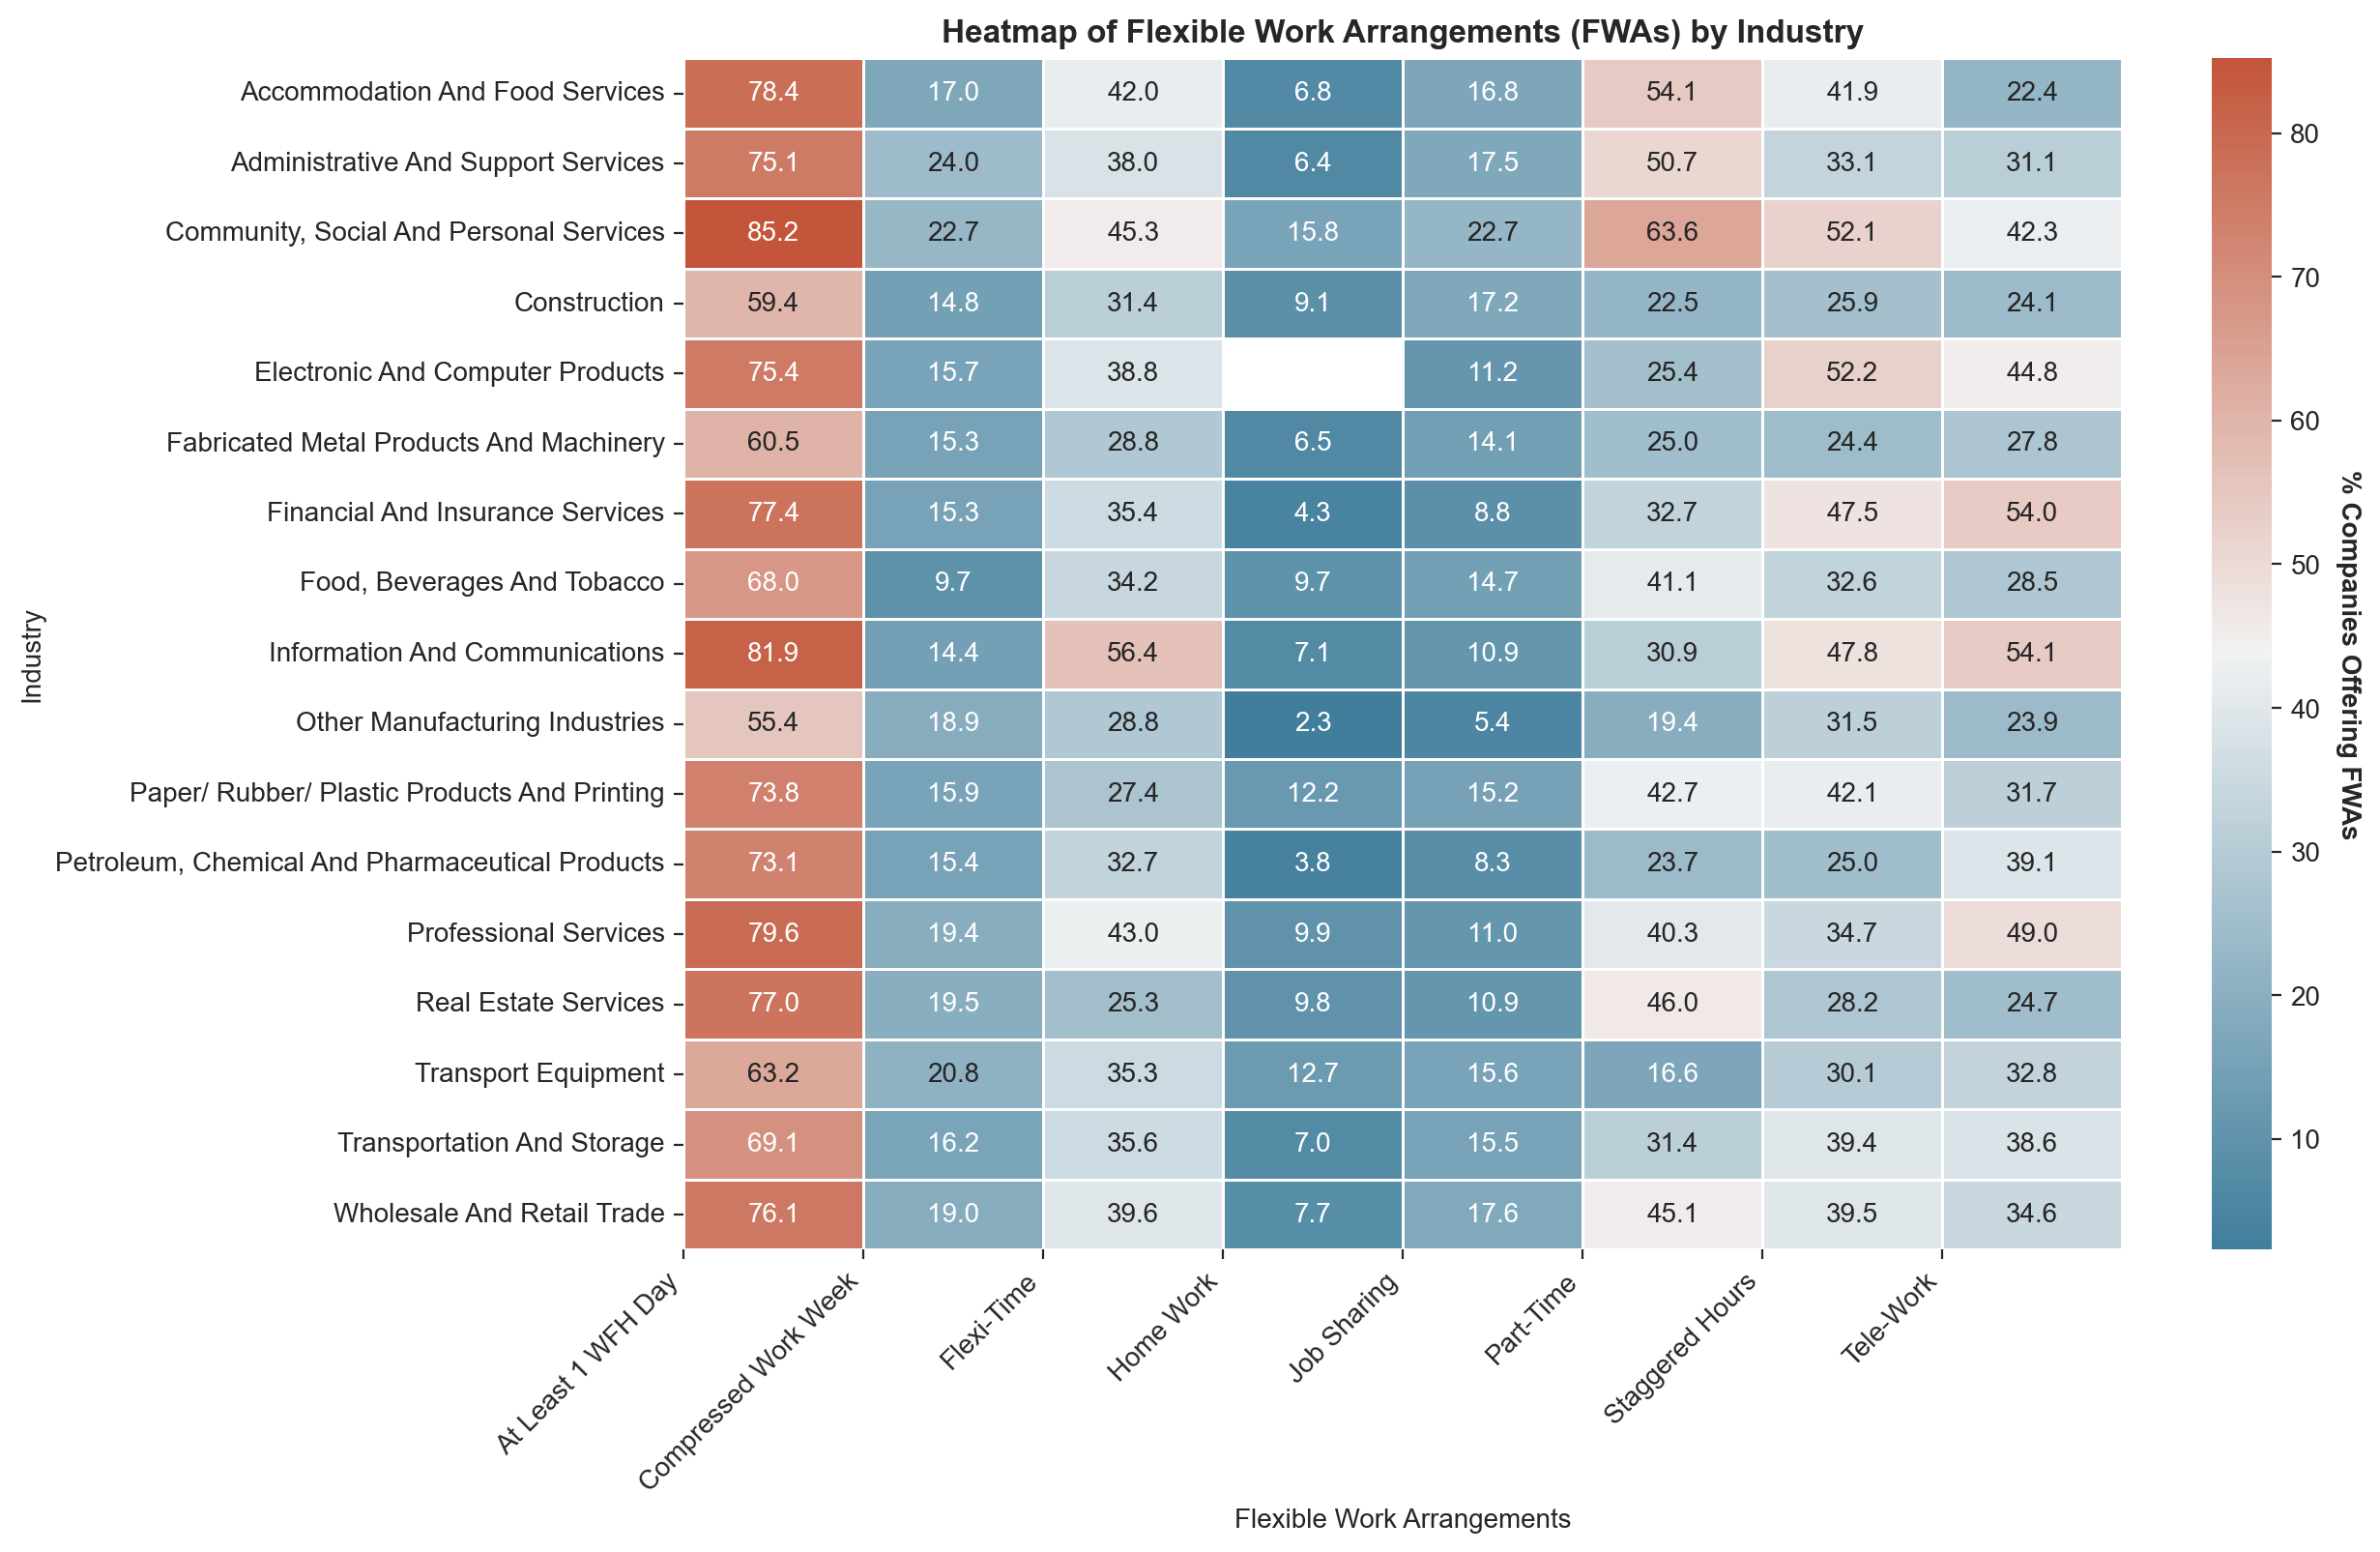

In [11]:
# Extract 2022 WFH data
query = '''
SELECT * FROM WFH
WHERE YEAR = 2022
'''
wfh = pd.read_sql(query, con)

# Data cleaning
wfh_melt = wfh.melt(id_vars=['INDUSTRY1', 'INDUSTRY2', 'INDUSTRY3'], value_vars=['AT_LEAST_ONE', 'PART_TIME', 'FLEX_TIME', 'STAGGERED_HOURS', 'TELE_WORK', 'HOME_WORK', 'JOB_SHARING', 'COMPRESSED_WEEK'], var_name='WFH_TYPE').groupby(['INDUSTRY1', 'INDUSTRY2', 'WFH_TYPE'])['value'].mean().reset_index()
wfh_melt['INDUSTRY2'] = wfh_melt['INDUSTRY2'].str.title()
wfh_melt.drop(columns='INDUSTRY1', inplace=True)
wfh_pivot_cleaned = pd.pivot(data=wfh_melt, index='INDUSTRY2', columns='WFH_TYPE', values='value')

# Plot figure
plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_style('ticks')

ax = sns.heatmap(wfh_pivot_cleaned, annot=True, fmt='.1f', linewidths=0.5, cmap=cmap)
plt.title('Heatmap of Flexible Work Arrangements (FWAs) by Industry', weight='bold')
plt.ylabel('Industry')
plt.xlabel('Flexible Work Arrangements')
plt.yticks(size=10)
plt.xticks(np.arange(len(wfh_pivot_cleaned.columns)), ['At Least 1 WFH Day', 'Compressed Work Week', 'Flexi-Time', 'Home Work', 'Job Sharing', 'Part-Time', 'Staggered Hours', 'Tele-Work'], 
           rotation=45, ha='right', size=10)
# plt.legend(title='% Companies', bbox_to_anchor=(1.175, 1.05), title_fontproprerties='bold')

colorbar = ax.collections[0].colorbar
colorbar.set_label('% Companies Offering FWAs', weight='bold', verticalalignment='top', labelpad=15, rotation=270)

plt.show()

<u><b>Analysis</b></u><br>
Job-seekers are increasingly prioritising the availability of flexible working arrangements. Galvanised by the COVID-19 pandemic, such options have become mainstream and are now a standard expectation in today's workplace. As such, this analysis compares the flexible working arrangements offered by various industries to help job-seekers determine industries with the greatest flexibility to maintain good work-life balance.

<u><b>Insights</b></u><br>
Nearly all industries have at least 60% of companies offering at least one day of working from home (WFH). However, compressed workweeks are still uncommon, with less than 20% of companies providing this option. Similarly, full-time home work and job-sharing are also rare. Part-time work is most prevalent in the Services sector, with some companies offering staggered working hours.

The use of staggered hours is notably high not only in the Financial and Insurance Services and Information and Communications industries (>40%) but also in the Electronic and Computer Products, and Community, Social and Personal Services industries (>50%). Tele-work (or remote working) is most common in the Financial and Insurance Services industry and the Information and Communications Industry, where over 50% of companies provide this option.

For job-seekers seeking the most flexible working arrangements, the Financial and IT-related industries, as well as service-related industries for part-time roles, or the Community, Social and Personal Services sector for flexible working conditions, may be the best options.

# 3. Limitations of Study <a id = '3'></a> 
This study examined the various facets of the labour market across different industries. However, the analysis was limited by the use of aggregated topline data, which restricted the ability to delve into more detailed and meaningful trends. 

Moreover, the study did not differentiate between residential and non-residential employment. Future research could explore this distinction further to allow different segments of the working force to make more informed decisions in their job-search.

Additionally, other factors influencing job satisfaction were not considered in this study. Future studies could focus on exploring additional indicators, such as workplace relations, through surveys targeting specific industries.

# 4. Conclusion <a id = '4'></a> 
Despite economic challenges, Singapore’s job market demonstrates resilience and performs well compared to other countries. While the pursuit of job benefits is important, job-seekers need to carefully and strategically balance with job security in both the short and long-term.

While the labour market within Singapore may be tight now, the potential for growth opportunities exists. Staying adaptable and prepared will be crucial for capitalising on future opportunities when markets recover.